In [272]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [284]:
pip install opencv-python-headless pillow numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 8.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.formula.api as smf
import time
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googleapiclient.discovery import build
import requests
import json
from PIL import Image
import cv2
from io import BytesIO
from sklearn.preprocessing import StandardScaler

In [211]:
pbmega = pd.read_csv('PBmegadata.csv')
pbmacro = pd.read_csv('PBmacrodata.csv')
pbmicro = pd.read_csv('PBmicrodata.csv')
entmega = pd.read_csv('Entmegadata.csv')
entmacro = pd.read_csv('Entmacrodata.csv')
entmicro = pd.read_csv('Entmicrodata.csv')

In [212]:
df_raw = pd.concat([pbmega, pbmacro, pbmicro, entmega, entmacro, entmicro], ignore_index=True)
print(df_raw.shape) 
print(df_raw.info())

(185197, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185197 entries, 0 to 185196
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   video_id       185197 non-null  object 
 1   title          185197 non-null  object 
 2   upload_date    185197 non-null  int64  
 3   view_count     185197 non-null  int64  
 4   like_count     178561 non-null  float64
 5   comment_count  153910 non-null  float64
 6   description    135883 non-null  object 
 7   thumbnail      185197 non-null  object 
 8   channel_url    185197 non-null  object 
 9   category       185197 non-null  object 
 10  size           185197 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 15.5+ MB
None


In [213]:
df_raw.head(1)

,video_id,title,upload_date,view_count,like_count,comment_count,description,thumbnail,channel_url,category,size
0,WjQMBILy7q4,4 YouTuber Homes You Won’t Believe Exist!,20250518,35004135,390253.0,8900.0,We toured the most expensive and fun YouTube H...,https://i.ytimg.com/vi/WjQMBILy7q4/maxresdefau...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,mega


In [251]:
print(len(df_raw['channel_url'].unique()))

419


# Data Prepartation

## Engagement Visibility Filter

In [215]:
dforiginal = df_raw.dropna()
dforiginal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108851 entries, 0 to 185189
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   video_id       108851 non-null  object 
 1   title          108851 non-null  object 
 2   upload_date    108851 non-null  int64  
 3   view_count     108851 non-null  int64  
 4   like_count     108851 non-null  float64
 5   comment_count  108851 non-null  float64
 6   description    108851 non-null  object 
 7   thumbnail      108851 non-null  object 
 8   channel_url    108851 non-null  object 
 9   category       108851 non-null  object 
 10  size           108851 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 10.0+ MB


In [216]:
print(len(dforiginal['channel_url'].unique()))

393


## Date Filter

In [217]:
dforiginal["upload_date"] = pd.to_datetime(dforiginal["upload_date"], format="%Y%m%d", errors="coerce")

start_date = pd.Timestamp("2022-06-01")
end_date = pd.Timestamp("2024-06-01")

df_datefiltered = dforiginal[(dforiginal["upload_date"] >= start_date) & (dforiginal["upload_date"] < end_date)]
df_datefiltered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34121 entries, 18 to 184803
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       34121 non-null  object        
 1   title          34121 non-null  object        
 2   upload_date    34121 non-null  datetime64[ns]
 3   view_count     34121 non-null  int64         
 4   like_count     34121 non-null  float64       
 5   comment_count  34121 non-null  float64       
 6   description    34121 non-null  object        
 7   thumbnail      34121 non-null  object        
 8   channel_url    34121 non-null  object        
 9   category       34121 non-null  object        
 10  size           34121 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 3.1+ MB


/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/3012066519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dforiginal["upload_date"] = pd.to_datetime(dforiginal["upload_date"], format="%Y%m%d", errors="coerce")


In [218]:
print(len(df_datefiltered['channel_url'].unique()))

333


## Activity Level Filter

In [223]:
df_filtered = df_datefiltered[
    df_datefiltered.groupby("channel_url")["video_id"].transform("count") >= 8]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33945 entries, 18 to 184803
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       33945 non-null  object        
 1   title          33945 non-null  object        
 2   upload_date    33945 non-null  datetime64[ns]
 3   view_count     33945 non-null  int64         
 4   like_count     33945 non-null  float64       
 5   comment_count  33945 non-null  float64       
 6   description    33945 non-null  object        
 7   thumbnail      33945 non-null  object        
 8   channel_url    33945 non-null  object        
 9   category       33945 non-null  object        
 10  size           33945 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 3.1+ MB


In [224]:
print(len(df_filtered['channel_url'].unique()))

277


## Sponsored Content Filter

In [225]:
def detect_sponsorship(text):
    if pd.isna(text):
        return "organic"
    t = text.lower()

    # 一樣先跑一輪「明確表非業配」的否定片語
    negative_clues = [
        r"\bnot sponsored\b",
        r"\bthis video is not sponsored\b",
        r"\bno sponsor\b",
        r"\bnot a paid promotion\b",
        r"\bno paid promotion\b",
        r"\bwithout sponsorship\b",
        r"\bunsponsored\b",
        r"\bno ads?\b",
        r"\bno advertisement\b",
        r"\bthank you(?: for watching| guys)?\b"
    ]
    for pat in negative_clues:
        if re.search(pat, t):
            return "organic"

    # 強化版的「業配關鍵詞／片語」（同時保留 word-boundary 與 partial match）
    positive_clues = [
        # 明確 hashtag
        r"#ad\b", r"#sponsored\b", r"#sponsor\b",
        # 片語 match
        r"paid promotion", r"paid partnership", r"paid collabo", 
        r"partner(?:ed|ship)? with", r"in partnership with", 
        r"in collaboration with", r"collab", 
        r"brand deal", r"brand partnership", 
        r"brought to you by", r"presented by", 
        r"sponsored by", r"supported by",
        r"this content is funded by", 
        r"gifted (?:product|items|services)?",
        r"affiliate", 
        # 一般名詞
        r"\bsponsor(?:ed|)\b", r"advertis",  # match advertisement, advertising
        r"\bad\b",  # catch standalone ad (but beware false positives)
        r"use code\b", r"promo code\b"
    ]
    for pat in positive_clues:
        if re.search(pat, t):
            return "sponsored"

    return "organic"

In [226]:
df_filtered["sponsorship"] = df_filtered["description"].apply(detect_sponsorship)
print(df_filtered["sponsorship"].value_counts())

sponsorship
organic      31177
sponsored     2768
Name: count, dtype: int64


/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/3819534558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["sponsorship"] = df_filtered["description"].apply(detect_sponsorship)


In [227]:
df_filtered = df_filtered.groupby('channel_url') \
                         .filter(lambda grp: grp['sponsorship'].eq('sponsored').any())
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19022 entries, 18 to 180760
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       19022 non-null  object        
 1   title          19022 non-null  object        
 2   upload_date    19022 non-null  datetime64[ns]
 3   view_count     19022 non-null  int64         
 4   like_count     19022 non-null  float64       
 5   comment_count  19022 non-null  float64       
 6   description    19022 non-null  object        
 7   thumbnail      19022 non-null  object        
 8   channel_url    19022 non-null  object        
 9   category       19022 non-null  object        
 10  size           19022 non-null  object        
 11  sponsorship    19022 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 1.9+ MB


In [228]:
print(len(df_filtered['channel_url'].unique()))

138


## Data Distribution and Transformation

Text(0.5, 1.0, 'Distribution of comment_count')

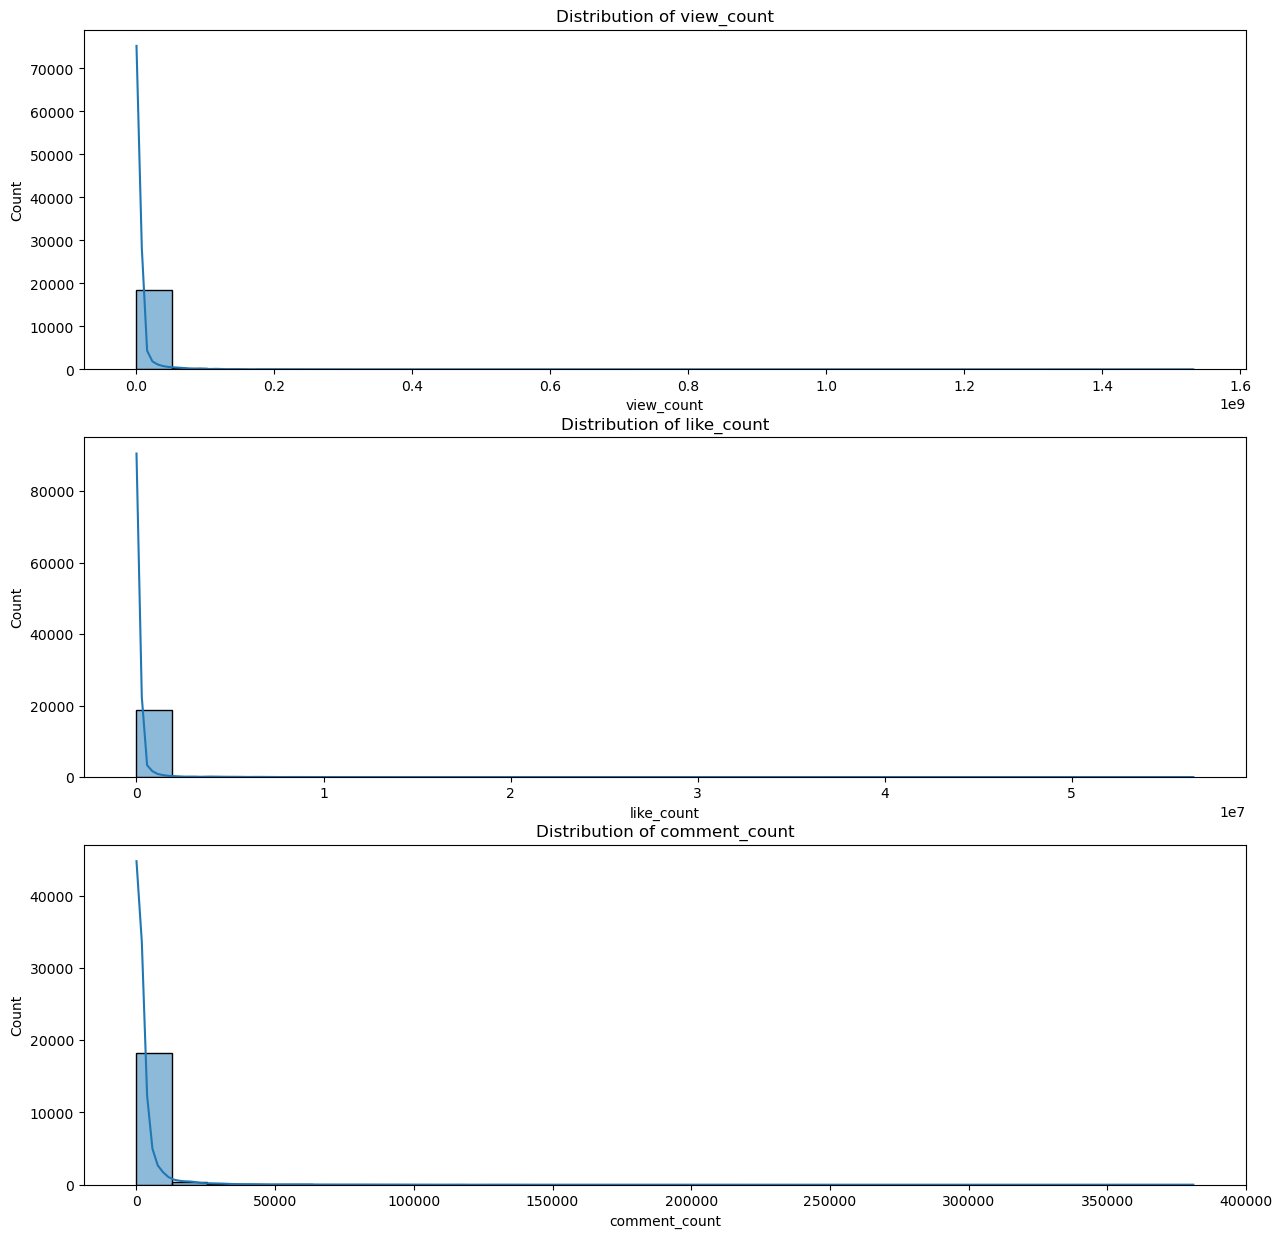

In [229]:
# Histograms for visualising distributions
plt.figure(figsize=(15, 15))

# Histogram for view_count
plt.subplot(3, 1, 1)
sns.histplot(df_filtered['view_count'], bins=30, kde=True)
plt.title('Distribution of view_count')

# Histogram for like_count
plt.subplot(3, 1, 2)
sns.histplot(df_filtered['like_count'], bins=30, kde=True)
plt.title('Distribution of like_count')

# Histogram for comment_count
plt.subplot(3, 1, 3)
sns.histplot(df_filtered['comment_count'], bins=30, kde=True)
plt.title('Distribution of comment_count')

Text(0.5, 1.0, 'Distribution of comment_count')

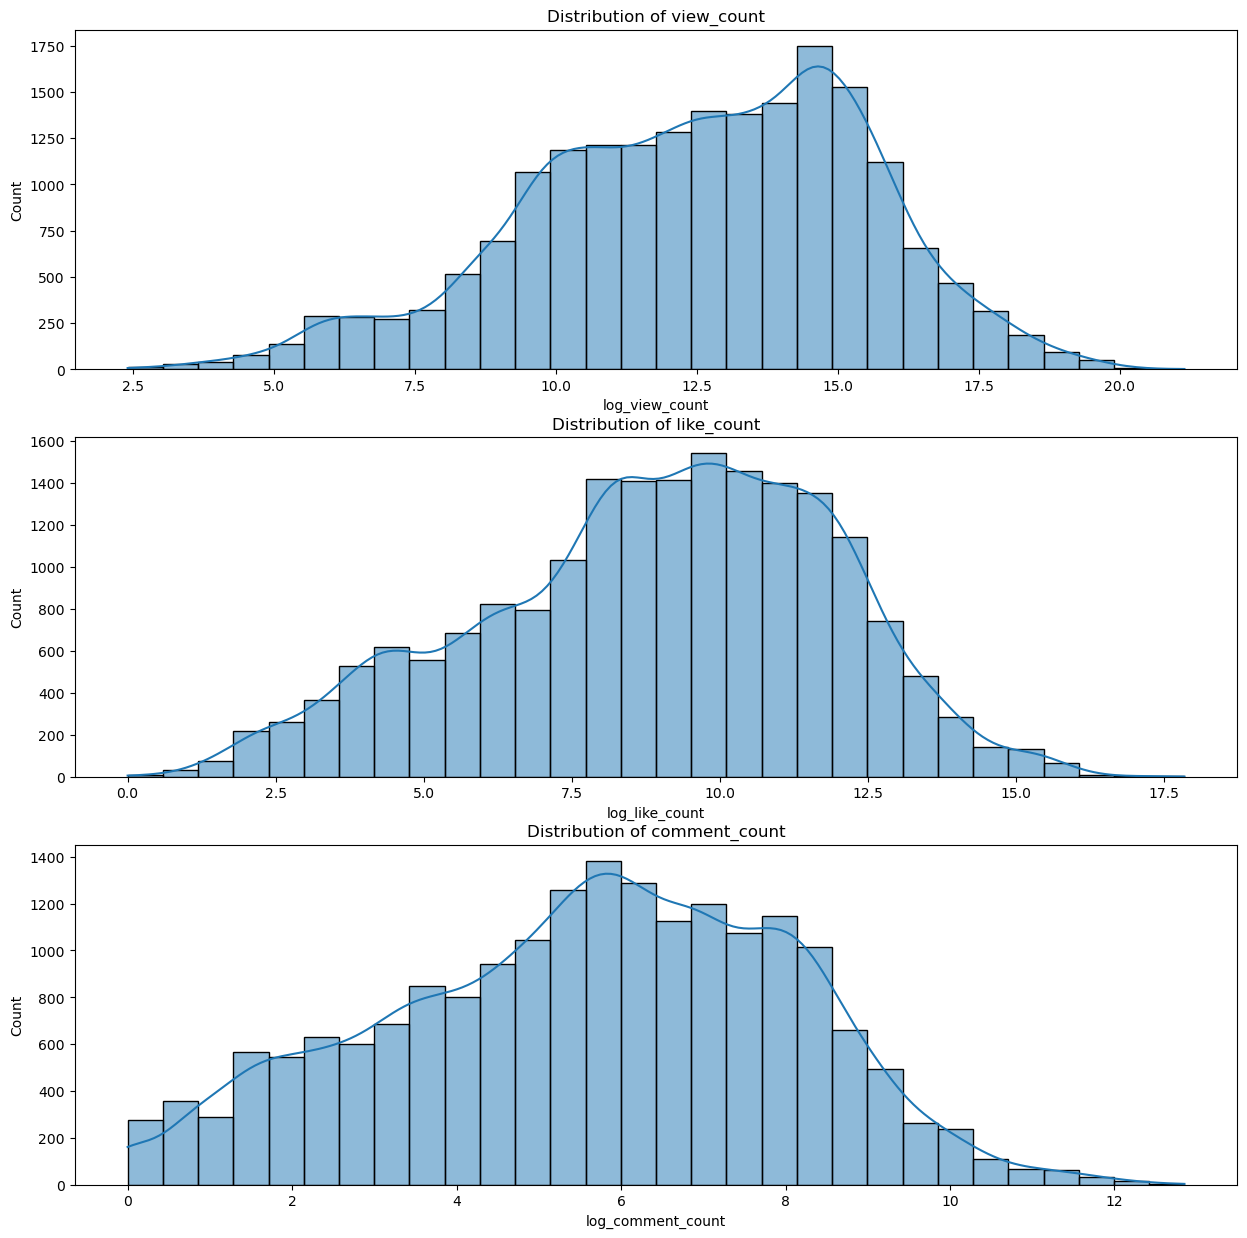

In [230]:
df = df_filtered

df['log_view_count'] = np.log(df['view_count'])
df['log_like_count'] = np.log(df['like_count'])
df['log_comment_count'] = np.log(df['comment_count'])

plt.figure(figsize=(15, 15))

# Histogram for view_count
plt.subplot(3, 1, 1)
sns.histplot(df['log_view_count'], bins=30, kde=True)
plt.title('Distribution of view_count')

# Histogram for like_count
plt.subplot(3, 1, 2)
sns.histplot(df['log_like_count'], bins=30, kde=True)
plt.title('Distribution of like_count')

# Histogram for comment_count
plt.subplot(3, 1, 3)
sns.histplot(df['log_comment_count'], bins=30, kde=True)
plt.title('Distribution of comment_count')

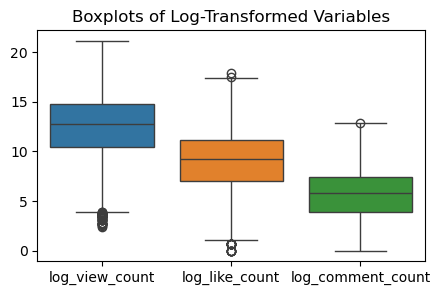

In [231]:
#boxplot to spot remaining outliers
plt.figure(figsize=(5, 3))
sns.boxplot(data=df[['log_view_count', 'log_like_count', 'log_comment_count']])
plt.title("Boxplots of Log-Transformed Variables")
plt.show()

In [232]:
def IQR_method(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = IQR_method(df, 'log_view_count')
df = IQR_method(df, 'log_like_count')
df = IQR_method(df, 'log_comment_count')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18954 entries, 18 to 180760
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           18954 non-null  object        
 1   title              18954 non-null  object        
 2   upload_date        18954 non-null  datetime64[ns]
 3   view_count         18954 non-null  int64         
 4   like_count         18954 non-null  float64       
 5   comment_count      18954 non-null  float64       
 6   description        18954 non-null  object        
 7   thumbnail          18954 non-null  object        
 8   channel_url        18954 non-null  object        
 9   category           18954 non-null  object        
 10  size               18954 non-null  object        
 11  sponsorship        18954 non-null  object        
 12  log_view_count     18954 non-null  float64       
 13  log_like_count     18954 non-null  float64       
 14  log_comme

In [233]:
print(len(df['channel_url'].unique()))

138


## Channel Sponsored Content PCT Column

<Axes: xlabel='sponsored_content_pct', ylabel='Count'>

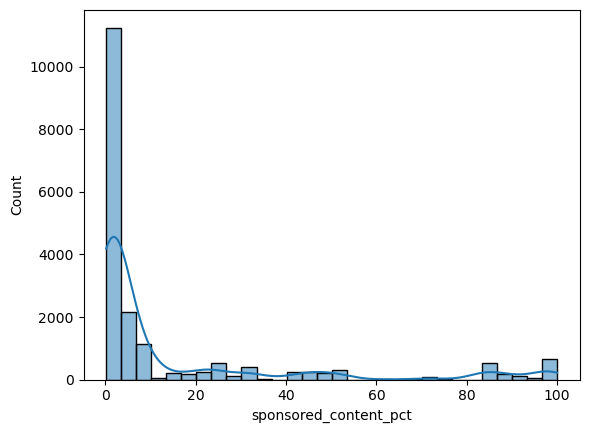

In [234]:
df['sponsored_content_pct'] = (
    df
    .groupby('channel_url')['sponsorship']
    .transform(lambda x: x.eq('sponsored').mean())) * 100
# eq send 1/0 back, and get the mean of it means to count the sum of 1s divided by the total number

df['sponsored_content_pct'] = df['sponsored_content_pct'].round(2)
sns.histplot(df['sponsored_content_pct'], bins=30, kde=True)

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18954 entries, 18 to 180760
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   video_id               18954 non-null  object        
 1   title                  18954 non-null  object        
 2   upload_date            18954 non-null  datetime64[ns]
 3   view_count             18954 non-null  int64         
 4   like_count             18954 non-null  float64       
 5   comment_count          18954 non-null  float64       
 6   description            18954 non-null  object        
 7   thumbnail              18954 non-null  object        
 8   channel_url            18954 non-null  object        
 9   category               18954 non-null  object        
 10  size                   18954 non-null  object        
 11  sponsorship            18954 non-null  object        
 12  log_view_count         18954 non-null  float64       
 13  log_

In [236]:
all_sponsored_channels = df.loc[
    df['sponsored_content_pct'] == 100, 
    'channel_url'
].unique()

print(all_sponsored_channels)

df = df[~df['channel_url'].isin(all_sponsored_channels)]

# reset index
df = df.reset_index(drop=True)

df.info()

['https://www.youtube.com/@BaileyB/videos']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18937 entries, 0 to 18936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   video_id               18937 non-null  object        
 1   title                  18937 non-null  object        
 2   upload_date            18937 non-null  datetime64[ns]
 3   view_count             18937 non-null  int64         
 4   like_count             18937 non-null  float64       
 5   comment_count          18937 non-null  float64       
 6   description            18937 non-null  object        
 7   thumbnail              18937 non-null  object        
 8   channel_url            18937 non-null  object        
 9   category               18937 non-null  object        
 10  size                   18937 non-null  object        
 11  sponsorship            18937 non-null  object        
 12  log_view_count  

In [237]:
print(len(df['channel_url'].unique()))

137


In [238]:
df.to_csv("df.csv", index=False)

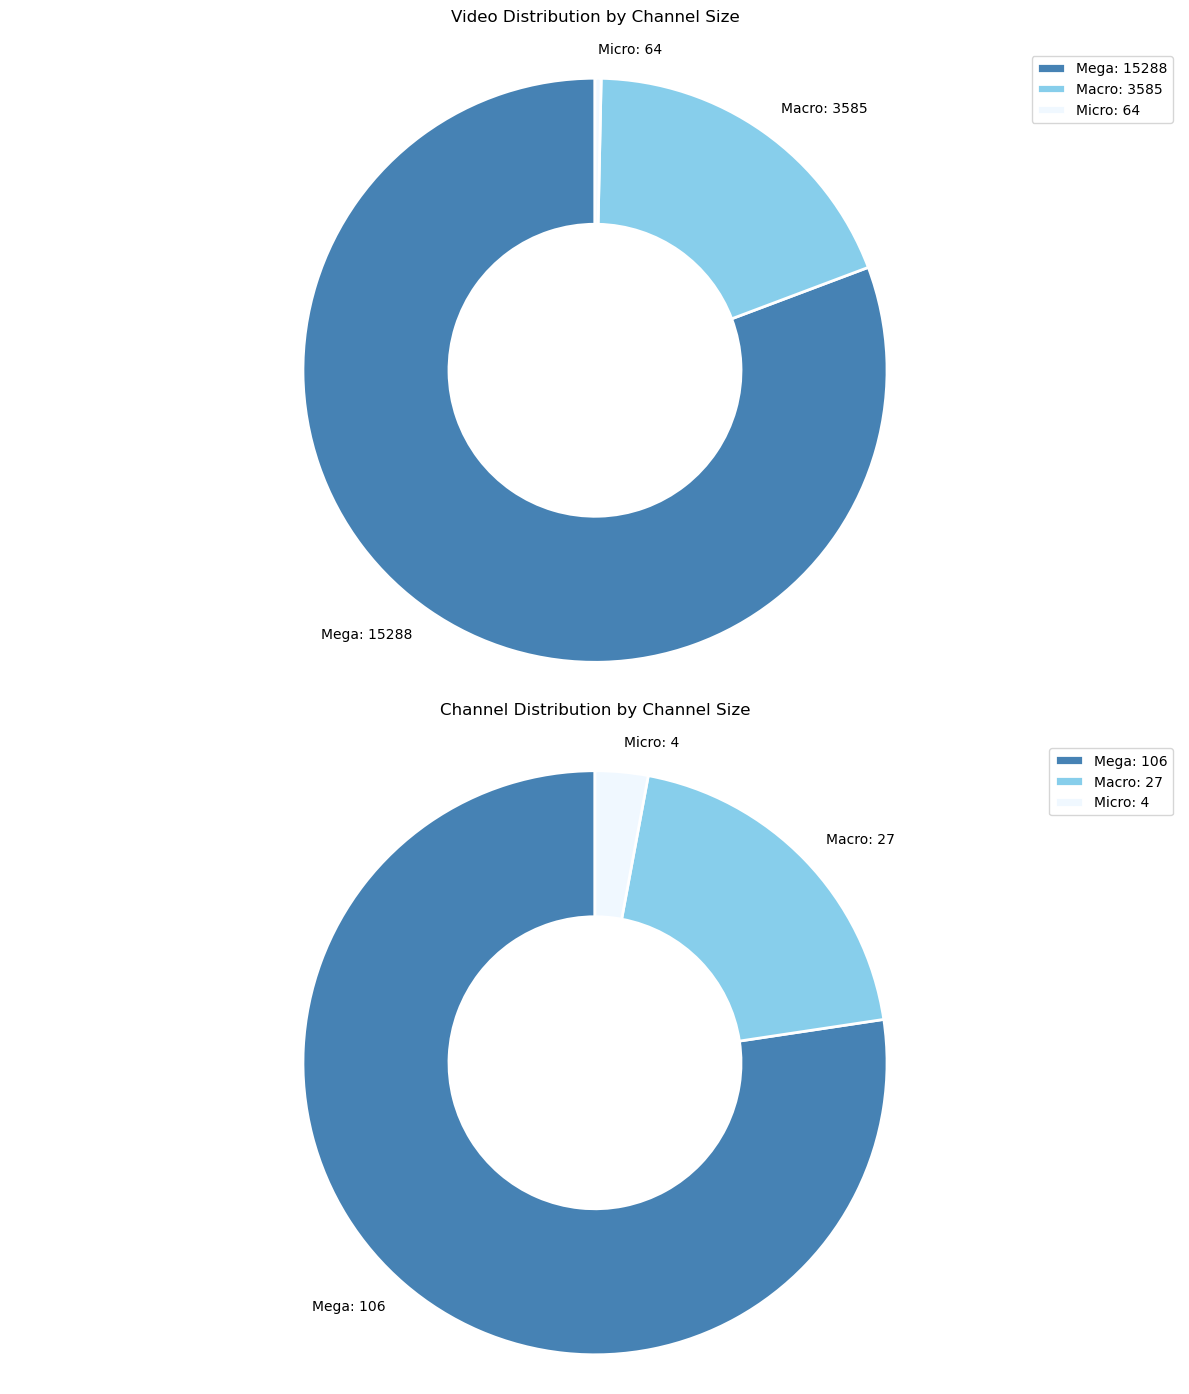

In [277]:
sizes  = ['mega', 'macro', 'micro']
colors = ['steelblue', 'skyblue', 'aliceblue']

# 1) 計算「影片」分布 by size
video_counts = [df.query("size == @sz").shape[0] for sz in sizes]
video_labels = [f"{sz.capitalize()}: {c}" for sz, c in zip(sizes, video_counts)]

# 2) 計算「頻道」分布 by size (取每個 channel_url 第一筆 size)
df_channels = df.groupby('channel_url')['size'].first().reset_index()
channel_counts = [df_channels.query("size == @sz").shape[0] for sz in sizes]
channel_labels = [f"{sz.capitalize()}: {c}" for sz, c in zip(sizes, channel_counts)]

# 3) 畫兩張子圖：上面影片分布，下面頻道分布
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# 上：Video by Size
axes[0].pie(
    video_counts,
    labels=video_labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth':2, 'edgecolor':'w', 'width':0.5}
)
axes[0].set_title('Video Distribution by Channel Size', y=1.03)
axes[0].axis('equal')
axes[0].legend(loc='upper right')

# 下：Channel by Size
axes[1].pie(
    channel_counts,
    labels=channel_labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth':2, 'edgecolor':'w', 'width':0.5}
)
axes[1].set_title('Channel Distribution by Channel Size', y=1.03)
axes[1].axis('equal')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

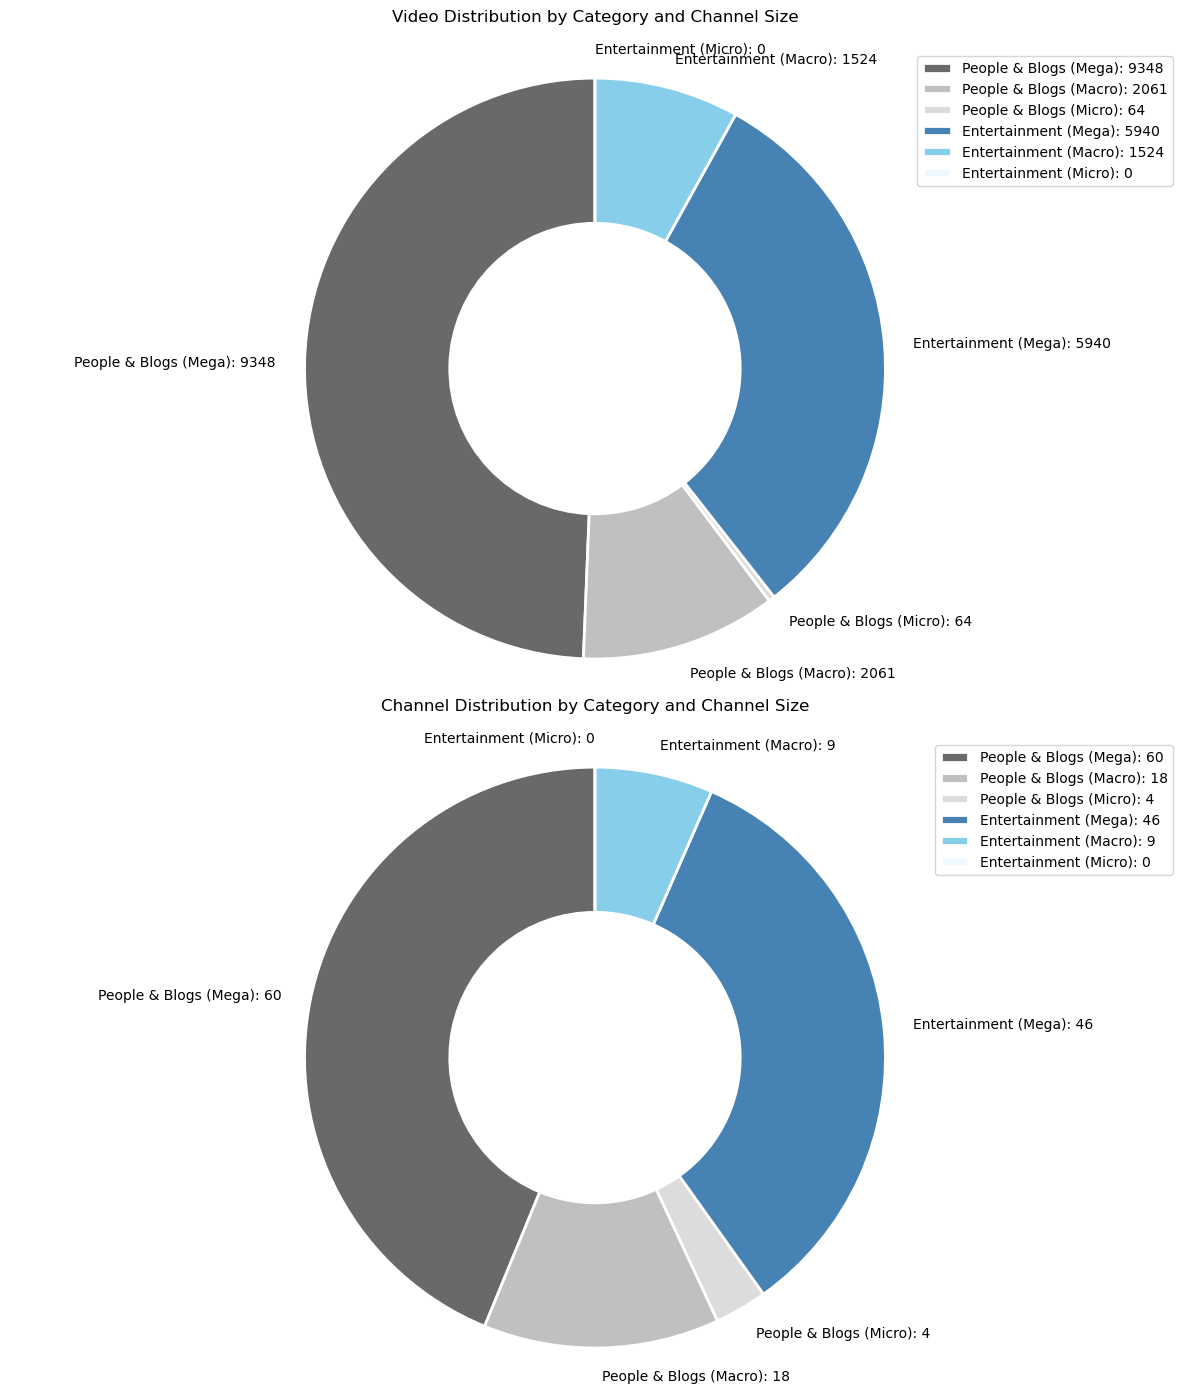

In [241]:
categories = ['People & Blogs', 'Entertainment']
sizes     = ['mega', 'macro', 'micro']
colors    = ['dimgrey', 'silver', 'gainsboro', 'steelblue', 'skyblue', 'aliceblue']

# 1) 計算「影片」分布
video_counts = []
video_labels = []
for cat in categories:
    for sz in sizes:
        c = df.query("category == @cat and size == @sz").shape[0]
        video_counts.append(c)
        video_labels.append(f"{cat} ({sz.capitalize()}): {c}")

# 2) 計算「頻道」分布
#    先每個 channel_url 取第一筆的 category & size
df_channels = (
    df
    .groupby('channel_url')[['category','size']]
    .first()
    .reset_index()
)

channel_counts = []
channel_labels = []
for cat in categories:
    for sz in sizes:
        c = df_channels.query("category == @cat and size == @sz").shape[0]
        channel_counts.append(c)
        channel_labels.append(f"{cat} ({sz.capitalize()}): {c}")

# 3) 畫兩個子圖：左邊影片分布，右邊頻道分布
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# 左：Video Distribution
axes[0].pie(
    video_counts,
    labels=video_labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth':2, 'edgecolor':'w', 'width':0.5}
)
axes[0].set_title('Video Distribution by Category and Channel Size', y=1.03)
axes[0].axis('equal')
axes[0].legend(loc= "upper right")

# 右：Channel Distribution
axes[1].pie(
    channel_counts,
    labels=channel_labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth':2, 'edgecolor':'w', 'width':0.5}
)
axes[1].set_title('Channel Distribution by Category and Channel Size', y=1.03)
axes[1].axis('equal')
axes[1].legend(loc= "upper right")

plt.tight_layout()
plt.show()

count    137.00
mean     138.23
std      133.40
min        7.00
25%       40.00
50%       91.00
75%      200.00
max      573.00
Name: video_count, dtype: float64
Median videos per channel: 91.0
Mode videos per channel:   8


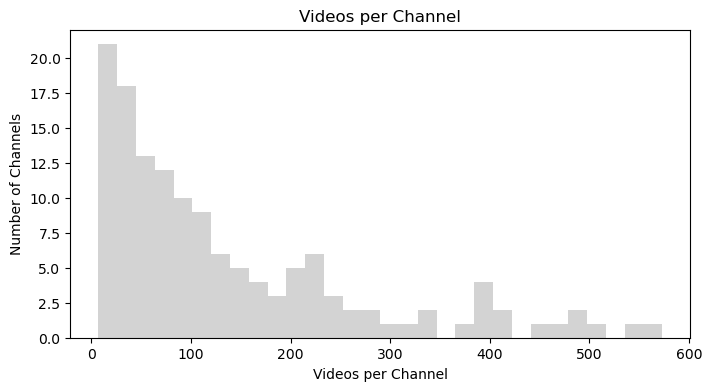

In [276]:
# 計算每個 channel_url 的影片數
channel_counts = (
    df
    .groupby('channel_url')['video_id']
    .count()
    .reset_index(name='video_count')
)

# 摘要統計（平均、中位數、四分位數、最大/最小值等）
print((channel_counts['video_count'].describe()).round(2))

# 中位數和眾數
median_count = channel_counts['video_count'].median()
mode_count   = channel_counts['video_count'].mode().iloc[0]
print(f"Median videos per channel: {median_count}")
print(f"Mode videos per channel:   {mode_count}")

plt.figure(figsize=(8,4))
plt.hist(channel_counts['video_count'], bins=30, color='lightgray')
plt.xlabel('Videos per Channel')
plt.ylabel('Number of Channels')
plt.title('Videos per Channel')
plt.show()

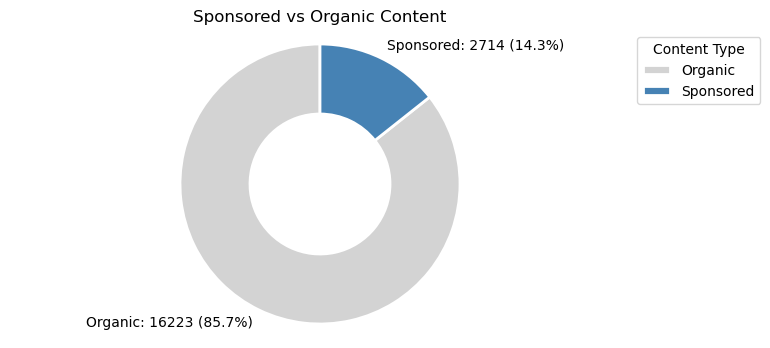

In [243]:
counts = df['sponsorship'].value_counts().reindex(['organic', 'sponsored']).fillna(0)
total = counts.sum()

labels = [
    f"Organic: {counts['organic']} ({counts['organic']/total*100:.1f}%)",
    f"Sponsored: {counts['sponsored']} ({counts['sponsored']/total*100:.1f}%)"
]

colors = ['lightgray', 'steelblue']

fig, ax = plt.subplots(figsize=(8, 4))
wedges, texts = ax.pie(
    counts,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'w', 'width': 0.5}
)

ax.set_title('Sponsored vs Organic Content')
ax.axis('equal')

ax.legend(
    wedges,
    ['Organic', 'Sponsored'],
    title='Content Type',
    loc='upper left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.show()

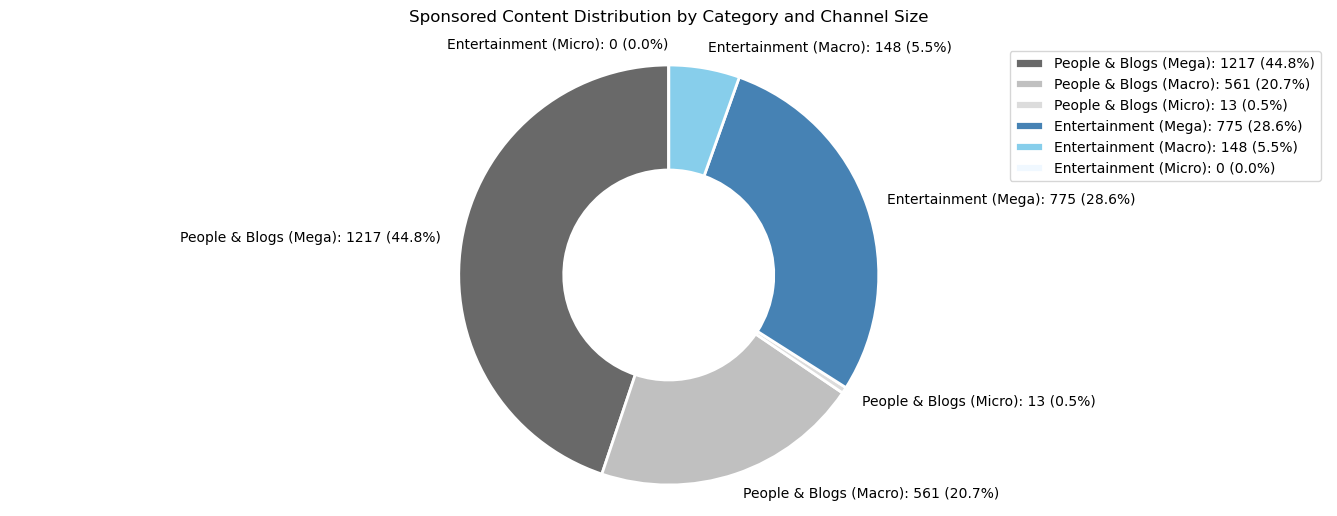

In [244]:
df_spon = df[df['sponsorship'] == 'sponsored'].copy()

# 2. 定義分類與頻道大小
categories = ['People & Blogs', 'Entertainment']
sizes      = ['mega', 'macro', 'micro']

# 3. 計算各組合的影片數，並同時計算百分比、組建 label
total_spon = len(df_spon)
counts = []
labels = []
for cat in categories:
    for sz in sizes:
        c = df_spon.query("category == @cat and size == @sz").shape[0]
        counts.append(c)
        pct = c / total_spon * 100
        labels.append(f"{cat} ({sz.capitalize()}): {c} ({pct:.1f}%)")

colors    = ['dimgrey', 'silver', 'gainsboro', 'steelblue', 'skyblue', 'aliceblue']

# 5. 繪製 doughnut chart
fig, ax = plt.subplots(figsize=(17, 6))
wedges, _ = ax.pie(
    counts,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'w', 'width': 0.5}
)

ax.set_title('Sponsored Content Distribution by Category and Channel Size', y=1.03)
ax.axis('equal')
ax.legend(loc='upper right')

plt.show()

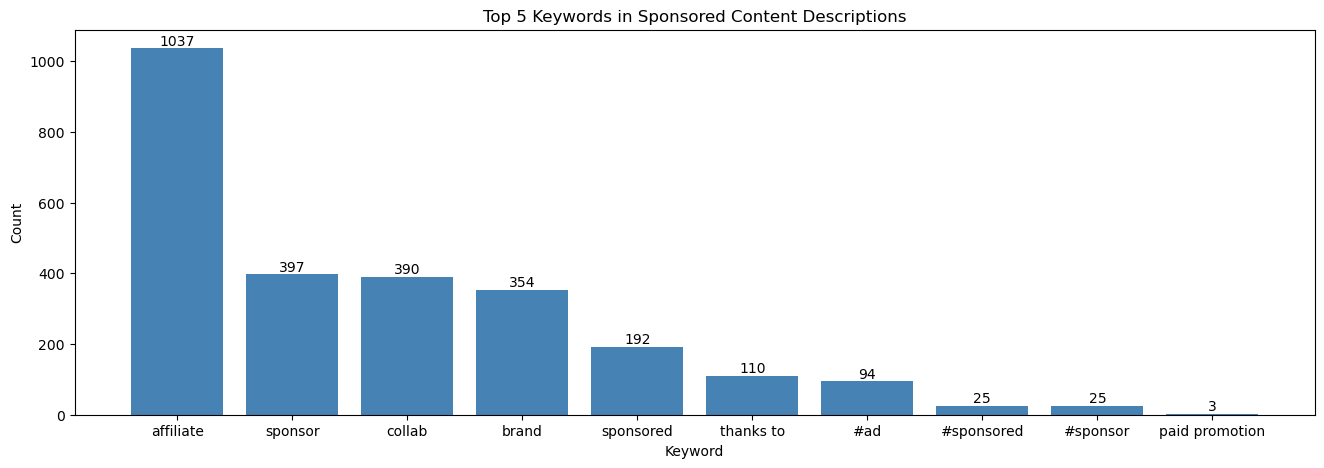

In [245]:
spon_keywords = [
    "sponsor", "sponsored", "paid promotion", "brand deal",
    "thanks to our sponsor", "brand", "advertisement",
    "#ad", "#sponsored", "#sponsor",
    "partnered with", "partnership with", "collab",
    "thanks to", "affiliate", "thank you"
]

# 2. 只取 sponsored 影片
df_spon = df[df['sponsorship'] == 'sponsored'].copy()

# 3. 計算每個關鍵字出現在 description 中的次數
kw_counts = {
    kw: df_spon['description']
            .str.lower()
            .str.contains(kw, regex=False)
            .sum()
    for kw in spon_keywords
}

# 4. 取出前五名
top5 = dict(sorted(kw_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# 5. 畫 bar chart
plt.figure(figsize=(16, 5))
bars = plt.bar(top5.keys(), top5.values(), color='steelblue')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Top 5 Keywords in Sponsored Content Descriptions')
plt.xticks()

# 6. 在每個 bar 上標出數字
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)),
             ha='center', va='bottom')

plt.show()

In [246]:
# 篩選出 description 中包含 "thank to" 的影片
thank_to_df = df[df['description'].str.lower().str.contains("gifted", na=False)]

# 查看部分結果
thank_to_df[['video_id', 'title', 'description']].head(10)

,video_id,title,description
1879,7OscxtUfR9M,The White Lotus's Haley Lu Richardson's Cute B...,27-year-old actor Haley Lu Richardson walks us...
3654,RzmGBhZsd6M,Am I The Grinch? | Reading Reddit Stories,We're searching for the biggest GRINCH of the ...
5388,hHdOPIUlqSQ,MAKING PAINT💧: 104 COLORS | art asmr,What was your favorite grinding moment? Mine's...
5389,ZjDEsGcDP24,MAKING PAINT: 104 COLORS (3 hours of art asmr),I'm giving away these paints! More information...
5391,HDGC4A8jsh4,New Art Supplies from Korea & London ✦ Art Vlog,Use code CHEFPEAR130 to get $130 off plus free...
12557,gsOXXdDvg8A,The President's Daughter is in DANGER,POV: The President's daughter is gifted a neck...
15835,Qe2V8xtkkdM,"""Deer and Present Danger"" A Very Merry Christm...",Can Pencilmate pull off the perfect heist of s...


In [282]:
# 1. 計算每個 channel_url 的 sponsored 影片數與 sponsored 百分比
channel_summary = df.groupby('channel_url').apply(lambda x: pd.Series({
    'sponsored_count': x['sponsorship'].eq('sponsored').sum(),
    'sponsored_pct': x['sponsorship'].eq('sponsored').mean() * 100
}))

# 2. 產生統計摘要並四捨五入
summary_stats = channel_summary.describe().round(2).T

# 3. 顯示結果
print(summary_stats)

                 count   mean    std  min   25%  50%    75%     max
sponsored_count  137.0  19.81  52.32  1.0  1.00  4.0   8.00  387.00
sponsored_pct    137.0  15.88  24.58  0.2  1.84  5.0  16.44   98.22


/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/2034871756.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  channel_summary = df.groupby('channel_url').apply(lambda x: pd.Series({


In [284]:
# 1. Like/View/Comment Count Statistic Summary
engagement_summary = (
    df[['view_count', 'like_count', 'comment_count']]
      .describe()
      .round(2)
      .T
)
print("1. Engagement Metrics Summary")
print(engagement_summary)

1. Engagement Metrics Summary
                 count        mean          std   min      25%       50%  \
view_count     18937.0  5858241.59  25321239.97  50.0  35065.0  364448.0   
like_count     18937.0   157809.38    748769.06   3.0   1122.0   10104.0   
comment_count  18937.0     2773.39     10832.93   1.0     48.0     327.0   

                     75%          max  
view_count     2653684.0  703744431.0  
like_count       70278.0   29782915.0  
comment_count     1700.0     288000.0  


In [287]:
# 2. Sponsored vs Organic Content’s Average Engagement Comparison
avg_engagement = (
    df
    .groupby('sponsorship')[['view_count', 'like_count', 'comment_count']]
    .mean()
    .round(2)
    .rename(columns={
        'view_count': 'avg_view_count',
        'like_count': 'avg_like_count',
        'comment_count': 'avg_comment_count'
    })
)
print("\n2. Average Engagement by Sponsorship")
print(avg_engagement)


2. Average Engagement by Sponsorship
             avg_view_count  avg_like_count  avg_comment_count
sponsorship                                                   
organic          6505620.53       174849.83            2984.67
sponsored        1988518.45        55949.66            1510.43


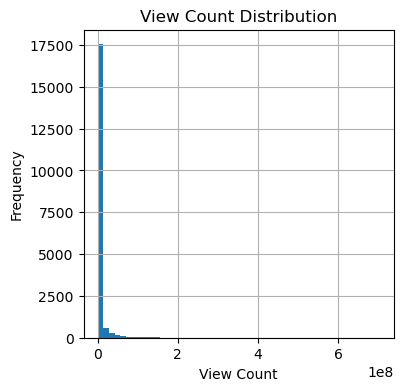

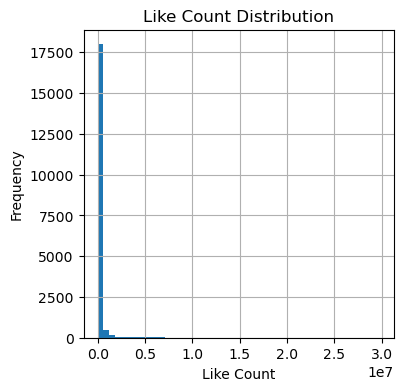

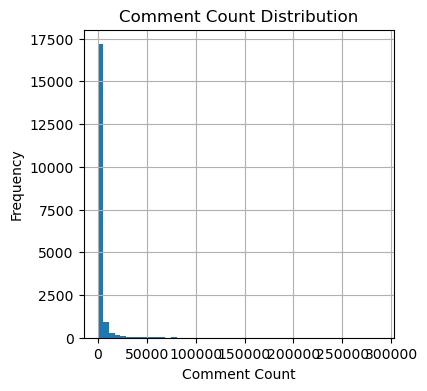

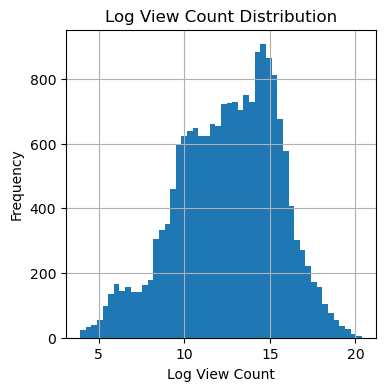

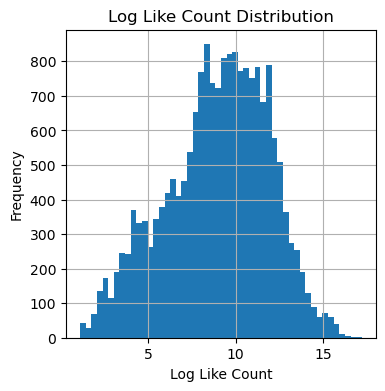

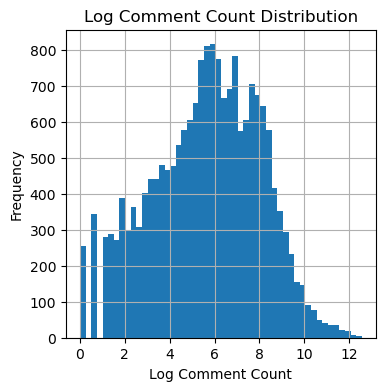

In [293]:
# 要繪製的指標
metrics = [
    ('view_count', 'View Count'),
    ('like_count', 'Like Count'),
    ('comment_count', 'Comment Count'),
    ('log_view_count', 'Log View Count'),
    ('log_like_count', 'Log Like Count'),
    ('log_comment_count', 'Log Comment Count')
]

# 依序畫圖
for col, title in metrics:
    plt.figure(figsize=(4, 4))
    plt.hist(df[col], bins=50)
    plt.title(f'{title} Distribution')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## Comment Sentiment Analysis Column

In [247]:
API_KEY = ["API1", "API2", "API3"]
youtube = build("youtube", "v3", developerKey=API_KEY)

input_path = "df.csv"
output_path = "comment_sentiment_columns.csv"  

In [248]:
analyzer = SentimentIntensityAnalyzer()
df = pd.read_csv(input_path)

target_videos = df["video_id"].tolist()
all_results = []

# continue mode
try:
    done_df = pd.read_csv(output_path)
    done_ids = set(done_df["video_id"])
    print(f"continue mode： {len(done_ids)} videos have been done so far")
    all_results = done_df.to_dict("records")
except:
    done_ids = set()

# === STEP 2: MAIN LOOP ===
def get_comments(video_id, max_comments=50):
    try:
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=max_comments,
            order="relevance",
            textFormat="plainText"
        ).execute()
        comments = [item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                    for item in response.get("items", [])]
        return comments
    except:
        return []

def analyze_sentiment(comments):
    pos, neu, neg = 0, 0, 0
    for c in comments:
        score = analyzer.polarity_scores(c)
        if score["compound"] >= 0.05:
            pos += 1
        elif score["compound"] <= -0.05:
            neg += 1
        else:
            neu += 1
    total = pos + neu + neg
    if total == 0:
        return 0, 0, 0, 0.0
    return pos, neu, neg, pos / total

for vid in tqdm(target_videos):
    if vid in done_ids:
        continue
    
    comments = get_comments(vid, max_comments=50)
    pos, neu, neg, pos_ratio = analyze_sentiment(comments)

    record = {
        "video_id": vid,
        "comment_total": len(comments),
        "pos_comments": pos,
        "neu_comments": neu,
        "neg_comments": neg,
        "positive_ratio": round(pos_ratio, 3)
    }
    all_results.append(record)

    # save the file every 100 videos
    if len(all_results) % 100 == 0:
        pd.DataFrame(all_results).to_csv(output_path, index=False)
        print(f"save, {len(all_results)} videos have been done")

    time.sleep(0.4)  # control the API request frequency

# final save
pd.DataFrame(all_results).to_csv(output_path, index=False)
print(f"all done! {len(all_results)} videos have been done and saved in {output_path}")

continue mode： 20202 videos have been done so far


 61%|██████████████████████▌              | 11546/18937 [01:00<02:30, 48.98it/s]

save, 20300 videos have been done


 62%|██████████████████████▊              | 11652/18937 [02:01<18:50,  6.44it/s]

save, 20400 videos have been done


 62%|█████████████████████▋             | 11762/18937 [03:04<1:09:13,  1.73it/s]

save, 20500 videos have been done


 63%|█████████████████████▉             | 11862/18937 [04:32<1:52:20,  1.05it/s]

save, 20600 videos have been done


 63%|██████████████████████             | 11962/18937 [06:05<1:43:38,  1.12it/s]

save, 20700 videos have been done


 64%|██████████████████████▎            | 12062/18937 [07:35<1:49:30,  1.05it/s]

save, 20800 videos have been done


 64%|██████████████████████▍            | 12162/18937 [09:15<1:45:10,  1.07it/s]

save, 20900 videos have been done


 65%|██████████████████████▋            | 12262/18937 [10:55<1:38:04,  1.13it/s]

save, 21000 videos have been done


 65%|██████████████████████▊            | 12362/18937 [12:32<1:47:35,  1.02it/s]

save, 21100 videos have been done


 66%|███████████████████████            | 12462/18937 [14:11<1:34:59,  1.14it/s]

save, 21200 videos have been done


 66%|███████████████████████▏           | 12562/18937 [15:39<1:25:53,  1.24it/s]

save, 21300 videos have been done


 67%|███████████████████████▍           | 12662/18937 [16:54<1:10:45,  1.48it/s]

save, 21400 videos have been done


 67%|███████████████████████▌           | 12762/18937 [18:15<1:23:06,  1.24it/s]

save, 21500 videos have been done


 68%|███████████████████████▊           | 12862/18937 [19:46<1:32:59,  1.09it/s]

save, 21600 videos have been done


 68%|███████████████████████▉           | 12962/18937 [21:23<1:24:50,  1.17it/s]

save, 21700 videos have been done


 69%|████████████████████████▏          | 13062/18937 [22:56<1:37:48,  1.00it/s]

save, 21800 videos have been done


 70%|█████████████████████████▋           | 13162/18937 [24:14<56:12,  1.71it/s]

save, 21900 videos have been done


 70%|████████████████████████▌          | 13262/18937 [25:18<1:00:13,  1.57it/s]

save, 22000 videos have been done


 71%|████████████████████████▋          | 13362/18937 [26:40<1:25:22,  1.09it/s]

save, 22100 videos have been done


 71%|██████████████████████████▎          | 13462/18937 [27:59<57:55,  1.58it/s]

save, 22200 videos have been done


 72%|█████████████████████████          | 13562/18937 [29:20<1:19:52,  1.12it/s]

save, 22300 videos have been done


 72%|█████████████████████████▎         | 13662/18937 [30:46<1:01:43,  1.42it/s]

save, 22400 videos have been done


 73%|█████████████████████████▍         | 13762/18937 [32:06<1:02:47,  1.37it/s]

save, 22500 videos have been done


 73%|█████████████████████████▌         | 13862/18937 [33:29<1:09:47,  1.21it/s]

save, 22600 videos have been done


 74%|███████████████████████████▎         | 13962/18937 [34:38<47:43,  1.74it/s]

save, 22700 videos have been done


 74%|█████████████████████████▉         | 14062/18937 [36:03<1:05:38,  1.24it/s]

save, 22800 videos have been done


 75%|██████████████████████████▏        | 14162/18937 [37:30<1:03:46,  1.25it/s]

save, 22900 videos have been done


 75%|██████████████████████████▎        | 14262/18937 [39:01<1:08:34,  1.14it/s]

save, 23000 videos have been done


 76%|████████████████████████████         | 14362/18937 [40:10<53:47,  1.42it/s]

save, 23100 videos have been done


 76%|████████████████████████████▎        | 14462/18937 [41:31<53:09,  1.40it/s]

save, 23200 videos have been done


 77%|██████████████████████████▉        | 14562/18937 [42:46<1:06:16,  1.10it/s]

save, 23300 videos have been done


 77%|███████████████████████████        | 14662/18937 [44:17<1:01:35,  1.16it/s]

save, 23400 videos have been done


 78%|███████████████████████████▎       | 14762/18937 [45:50<1:08:49,  1.01it/s]

save, 23500 videos have been done


 78%|███████████████████████████▍       | 14862/18937 [47:29<1:05:50,  1.03it/s]

save, 23600 videos have been done


 79%|█████████████████████████████▏       | 14962/18937 [49:07<45:29,  1.46it/s]

save, 23700 videos have been done


 80%|███████████████████████████▊       | 15062/18937 [50:34<1:01:32,  1.05it/s]

save, 23800 videos have been done


 80%|████████████████████████████       | 15162/18937 [52:10<1:04:39,  1.03s/it]

save, 23900 videos have been done


 81%|█████████████████████████████▊       | 15262/18937 [53:46<59:58,  1.02it/s]

save, 24000 videos have been done


 81%|████████████████████████████▍      | 15362/18937 [55:14<1:03:04,  1.06s/it]

save, 24100 videos have been done


 82%|████████████████████████████▌      | 15462/18937 [57:57<1:01:25,  1.06s/it]

save, 24200 videos have been done


 82%|██████████████████████████████▍      | 15562/18937 [59:16<42:21,  1.33it/s]

save, 24300 videos have been done


 83%|████████████████████████████▉      | 15662/18937 [1:00:40<34:31,  1.58it/s]

save, 24400 videos have been done


 83%|█████████████████████████████▏     | 15762/18937 [1:01:43<31:58,  1.66it/s]

save, 24500 videos have been done


 84%|█████████████████████████████▎     | 15862/18937 [1:02:50<34:15,  1.50it/s]

save, 24600 videos have been done


 84%|███████████████████████████▊     | 15962/18937 [1:05:14<1:01:49,  1.25s/it]

save, 24700 videos have been done


 85%|█████████████████████████████▋     | 16062/18937 [1:06:57<40:53,  1.17it/s]

save, 24800 videos have been done


 85%|█████████████████████████████▊     | 16162/18937 [1:08:46<52:20,  1.13s/it]

save, 24900 videos have been done


 86%|██████████████████████████████     | 16262/18937 [1:10:31<49:15,  1.10s/it]

save, 25000 videos have been done


 86%|██████████████████████████████▏    | 16362/18937 [1:12:20<44:48,  1.04s/it]

save, 25100 videos have been done


 87%|██████████████████████████████▍    | 16462/18937 [1:14:15<42:24,  1.03s/it]

save, 25200 videos have been done


 87%|██████████████████████████████▌    | 16562/18937 [1:16:01<39:43,  1.00s/it]

save, 25300 videos have been done


 88%|██████████████████████████████▊    | 16662/18937 [1:17:54<52:23,  1.38s/it]

save, 25400 videos have been done


 89%|██████████████████████████████▉    | 16762/18937 [1:19:48<42:14,  1.17s/it]

save, 25500 videos have been done


 89%|███████████████████████████████▏   | 16862/18937 [1:21:50<35:42,  1.03s/it]

save, 25600 videos have been done


 90%|███████████████████████████████▎   | 16962/18937 [1:25:35<37:15,  1.13s/it]

save, 25700 videos have been done


 90%|███████████████████████████████▌   | 17062/18937 [1:27:21<35:48,  1.15s/it]

save, 25800 videos have been done


 91%|███████████████████████████████▋   | 17162/18937 [1:29:16<49:42,  1.68s/it]

save, 25900 videos have been done


 91%|███████████████████████████████▉   | 17262/18937 [1:31:07<24:39,  1.13it/s]

save, 26000 videos have been done


 92%|████████████████████████████████   | 17362/18937 [1:32:53<27:54,  1.06s/it]

save, 26100 videos have been done


 92%|████████████████████████████████▎  | 17462/18937 [1:34:20<25:08,  1.02s/it]

save, 26200 videos have been done


 93%|████████████████████████████████▍  | 17562/18937 [1:35:45<14:14,  1.61it/s]

save, 26300 videos have been done


 93%|████████████████████████████████▋  | 17662/18937 [1:36:46<15:29,  1.37it/s]

save, 26400 videos have been done


 94%|████████████████████████████████▊  | 17762/18937 [1:37:43<10:45,  1.82it/s]

save, 26500 videos have been done


 94%|█████████████████████████████████  | 17862/18937 [1:38:47<13:31,  1.33it/s]

save, 26600 videos have been done


 95%|█████████████████████████████████▏ | 17962/18937 [1:39:45<09:42,  1.67it/s]

save, 26700 videos have been done


 95%|█████████████████████████████████▍ | 18062/18937 [1:40:47<09:07,  1.60it/s]

save, 26800 videos have been done


 96%|█████████████████████████████████▌ | 18162/18937 [1:41:49<08:12,  1.57it/s]

save, 26900 videos have been done


 96%|█████████████████████████████████▊ | 18262/18937 [1:42:53<07:20,  1.53it/s]

save, 27000 videos have been done


 97%|█████████████████████████████████▉ | 18362/18937 [1:43:57<06:15,  1.53it/s]

save, 27100 videos have been done


 97%|██████████████████████████████████ | 18462/18937 [1:45:01<04:52,  1.62it/s]

save, 27200 videos have been done


 98%|██████████████████████████████████▎| 18562/18937 [1:46:00<03:20,  1.87it/s]

save, 27300 videos have been done


 99%|██████████████████████████████████▍| 18662/18937 [1:46:57<02:30,  1.83it/s]

save, 27400 videos have been done


 99%|██████████████████████████████████▋| 18762/18937 [1:47:55<01:41,  1.72it/s]

save, 27500 videos have been done


100%|██████████████████████████████████▊| 18862/18937 [1:48:58<00:42,  1.77it/s]

save, 27600 videos have been done


100%|███████████████████████████████████| 18937/18937 [1:49:45<00:00,  2.88it/s]

all done! 27674 videos have been done and saved in comment_sentiment_columns.csv


In [249]:
comment_analysis = pd.read_csv('comment_sentiment_columns.csv')
df_with_comment = pd.merge(df, comment_analysis, on='video_id')

## Thumbnail Analysis Column

In [250]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

features = []

for url in tqdm(df_with_comment["thumbnail"]):
    try:
        # download the thumbnails
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

        # --- 色彩分析 ---
        hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        saturation = np.mean(s)
        brightness = np.mean(v)

        # --- 色溫推估（簡化法：R vs B 趨勢）---
        r, g, b = cv2.split(img_cv)
        temp_score = np.mean(r) - np.mean(b)  # > 0 偏暖，< 0 偏冷

        # --- 臉部辨識 ---
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        face_count = len(faces)

        features.append({
            "saturation": round(saturation, 2),
            "brightness": round(brightness, 2),
            "temperature": round(temp_score, 2),
            "face_count": face_count
        })

    except Exception as e:
        # 若圖片無法下載或解析，則給予預設值
        features.append({
            "saturation": np.nan,
            "brightness": np.nan,
            "temperature": np.nan,
            "face_count": np.nan
        })

pd.DataFrame(features).to_csv("thumbnail_analysis.csv", index=False)

100%|███████████████████████████████████| 18937/18937 [1:09:03<00:00,  4.57it/s]


In [252]:
thumbnail_analysis = pd.read_csv('thumbnail_analysis.csv')
df_all = pd.concat([df_with_comment, thumbnail_analysis], axis=1)

In [253]:
df_all.to_csv("final_data.csv", index=False)

In [254]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18937 entries, 0 to 18936
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   video_id               18937 non-null  object 
 1   title                  18937 non-null  object 
 2   upload_date            18937 non-null  object 
 3   view_count             18937 non-null  int64  
 4   like_count             18937 non-null  float64
 5   comment_count          18937 non-null  float64
 6   description            18937 non-null  object 
 7   thumbnail              18937 non-null  object 
 8   channel_url            18937 non-null  object 
 9   category               18937 non-null  object 
 10  size                   18937 non-null  object 
 11  sponsorship            18937 non-null  object 
 12  log_view_count         18937 non-null  float64
 13  log_like_count         18937 non-null  float64
 14  log_comment_count      18937 non-null  float64
 15  sp

<Axes: xlabel='positive_ratio', ylabel='Count'>

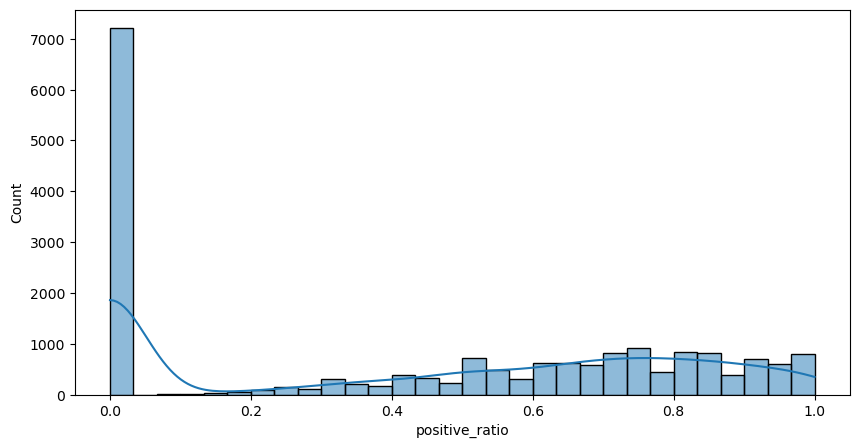

In [255]:
plt.figure(figsize=(10, 5))
sns.histplot(df_all['positive_ratio'], bins=30, kde=True)

In [256]:
# 1. title length：計算 title 欄位的字數
df_all['title_word_count'] = df_all['title'].str.split().str.len()

# 2. upper letters：計算 title 中大寫字母的數量
df_all['title_upper_letters'] = df_all['title'].str.count(r'[A-Z]')

# 3. description box length：計算 description 欄位的字數
df_all['description_word_count'] = df_all['description'].str.split().str.len()

In [257]:
df_all.head()

,video_id,title,upload_date,view_count,like_count,comment_count,description,thumbnail,channel_url,category,...,neu_comments,neg_comments,positive_ratio,saturation,brightness,temperature,face_count,title_word_count,title_upper_letters,description_word_count
0,LnVfvz_CJ1o,I Survived The World's STRICTEST School!,2024-05-24,154862016,1236562.0,35000.0,We tried surviving the World's strictest schoo...,https://i.ytimg.com/vi_webp/LnVfvz_CJ1o/maxres...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,...,2,4,0.88,106.56,179.64,21.31,4,6,14,31
1,71T_y3bnKCg,I Built 7 SECRET Rooms You'd Never Find!,2024-05-03,144398577,1326561.0,34000.0,We built 7 secret rooms to hide from our best ...,https://i.ytimg.com/vi_webp/71T_y3bnKCg/maxres...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,...,8,3,0.78,133.69,196.56,-16.58,3,8,12,50
2,eXosE1wewXg,I Built a SECRET 7-11 in My Room!,2024-04-12,114952967,1204884.0,28000.0,I built a secret 7/11 in my room and hid it fr...,https://i.ytimg.com/vi_webp/eXosE1wewXg/maxres...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,...,2,5,0.86,100.44,198.23,-40.35,1,8,10,38
3,xuvci7Tyg9U,Eating 100 Years of McDonalds!,2024-04-02,71810117,613967.0,19000.0,"We ate 100 years of MCDONALDS, prison, airplan...",https://i.ytimg.com/vi_webp/xuvci7Tyg9U/maxres...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,...,3,2,0.90,105.50,212.21,-15.74,1,5,4,29
4,-5bcG6tZKx8,I Built 5 SECRET Rooms You’d Never Find!,2024-03-26,177654667,1819954.0,27000.0,We built 5 secret rooms you’ve never seen befo...,https://i.ytimg.com/vi_webp/-5bcG6tZKx8/maxres...,https://www.youtube.com/@StokesTwins/videos,People & Blogs,...,9,9,0.64,162.84,223.00,62.16,4,8,12,45


# Data Visualisation

    upload_month  sponsored_count     avg_views     avg_likes  avg_comments  \
0              1              227  6.250184e+05  23851.722467    661.066079   
1              2               97  6.276202e+05  12734.010309    821.525773   
2              3              136  1.108322e+06  28755.786765   1088.963235   
3              4              113  1.155590e+06  39353.646018   1734.203540   
4              5              113  1.056548e+06  30363.787611   1011.743363   
5              6               81  3.781260e+06  61674.493827   2616.098765   
6              7               94  2.717553e+06  43176.553191   1527.212766   
7              8              110  2.170827e+06  35898.690909   1647.118182   
8              9              105  1.308396e+06  28912.009524   1093.352381   
9             10              126  8.071087e+05  14583.555556    685.690476   
10            11              115  1.263658e+06  40029.052174   1134.782609   
11            12              206  1.028826e+06  278

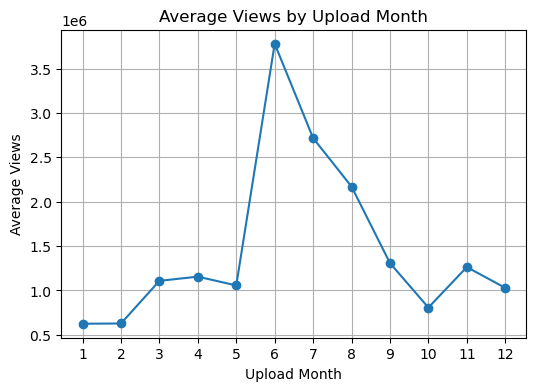

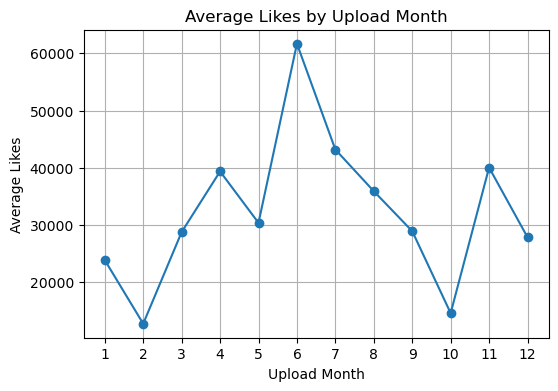

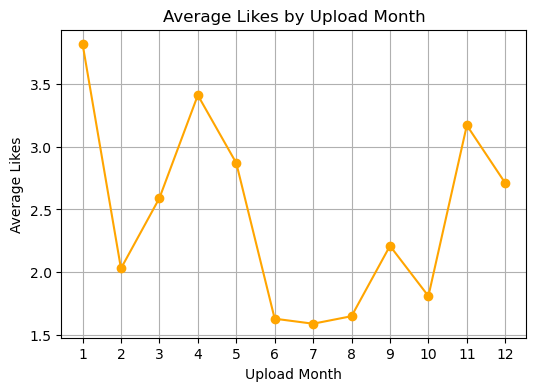

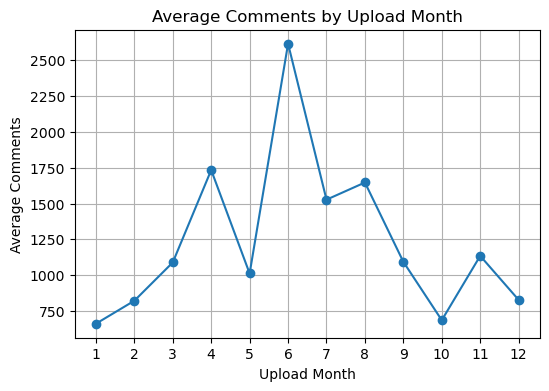

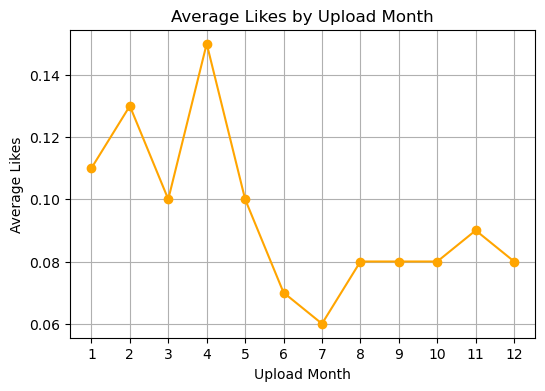

In [112]:
# 1. 只保留 sponsored 影片
sponsored_df = df_all[df_all['sponsorship'] == 'sponsored'].copy()

# 2. 確保 upload_date 是 datetime，並擷取月份
sponsored_df['upload_date'] = pd.to_datetime(sponsored_df['upload_date'])
sponsored_df['upload_month'] = sponsored_df['upload_date'].dt.month

# 3. 按月份彙整：計算每月 sponsored 影片數、平均觀看數、平均按讚數、平均留言數
monthly_stats = sponsored_df.groupby('upload_month').agg(
    sponsored_count = ('video_id',    'count'),
    avg_views        = ('view_count', 'mean'),
    avg_likes        = ('like_count', 'mean'),
    avg_comments     = ('comment_count','mean'),
).reset_index()

monthly_stats['like_view_pct'] = ((monthly_stats['avg_likes'] / monthly_stats['avg_views']) * 100).round(2)
monthly_stats['comment_view_pct'] = ((monthly_stats['avg_comments'] / monthly_stats['avg_views']) * 100).round(2)

# 4. 檢視彙整結果
print(monthly_stats)

# 1. Plot: Average Views by Month
plt.figure(figsize=(6, 4))
plt.plot(monthly_stats['upload_month'], monthly_stats['avg_views'], marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Upload Month')
plt.ylabel('Average Views')
plt.title('Average Views by Upload Month')
plt.grid(True)
plt.show()

# 2. Plot: Average Likes by Month
plt.figure(figsize=(6, 4))
plt.plot(monthly_stats['upload_month'], monthly_stats['avg_likes'], marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Upload Month')
plt.ylabel('Average Likes')
plt.title('Average Likes by Upload Month')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(monthly_stats['upload_month'], monthly_stats['like_view_pct'], marker='o', color='orange')
plt.xticks(range(1, 13))
plt.xlabel('Upload Month')
plt.ylabel('Average Likes')
plt.title('Average Likes by Upload Month')
plt.grid(True)
plt.show()

# 3. Plot: Average Comments by Month
plt.figure(figsize=(6, 4))
plt.plot(monthly_stats['upload_month'], monthly_stats['avg_comments'], marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Upload Month')
plt.ylabel('Average Comments')
plt.title('Average Comments by Upload Month')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(monthly_stats['upload_month'], monthly_stats['comment_view_pct'], marker='o', color='orange')
plt.xticks(range(1, 13))
plt.xlabel('Upload Month')
plt.ylabel('Average Likes')
plt.title('Average Likes by Upload Month')
plt.grid(True)
plt.show()

In [ ]:
可以去看沒被選到的頻道和被選到的頻道有什麼不同

# RQ1/ 

In [4]:
df_all = pd.read_csv('final_data.csv')

In [321]:
df_all["log_positive_ratio_eps"] = np.log(df_all["positive_ratio"] + 1e-6)
df_all["has_positive_comment"] = (df_all["positive_ratio"] > 0).astype(int)

In [322]:
thumbnail_vars = ['brightness', 'saturation', 'temperature', 'face_count']
scaler = StandardScaler()
df_all[[f"{var}_scaled" for var in thumbnail_vars]] = scaler.fit_transform(df_all[thumbnail_vars])

In [323]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18937 entries, 0 to 18936
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   video_id                                      18937 non-null  object 
 1   title                                         18937 non-null  object 
 2   upload_date                                   18937 non-null  object 
 3   view_count                                    18937 non-null  int64  
 4   like_count                                    18937 non-null  float64
 5   comment_count                                 18937 non-null  float64
 6   description                                   18937 non-null  object 
 7   thumbnail                                     18937 non-null  object 
 8   channel_url                                   18937 non-null  object 
 9   category                                      18937 non-null 

Positive Ratio Statistical Summary:
count    18937.00
mean         0.43
std          0.37
min          0.00
25%          0.00
50%          0.50
75%          0.76
max          1.00
Name: positive_ratio, dtype: float64


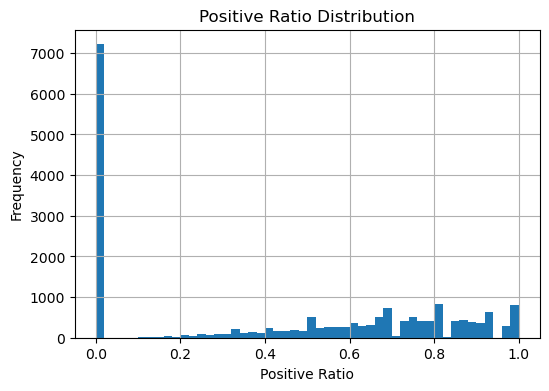

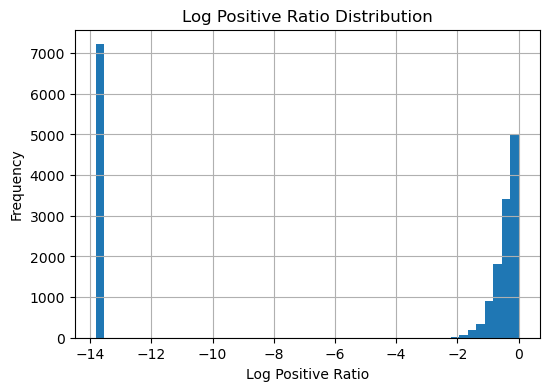

In [320]:
# 1. Positive Ratio 統計摘要
summary = df_all['positive_ratio'].describe().round(2)
print("Positive Ratio Statistical Summary:")
print(summary)

# 2. 繪製 positive_ratio 與 log_positive_ratio 的分布圖
metrics = [
    ('positive_ratio', 'Positive Ratio'),
    ('log_positive_ratio_eps', 'Log Positive Ratio')
]

for col, title in metrics:
    plt.figure(figsize=(6, 4))
    plt.hist(df_all[col], bins=50)
    plt.title(f'{title} Distribution')
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

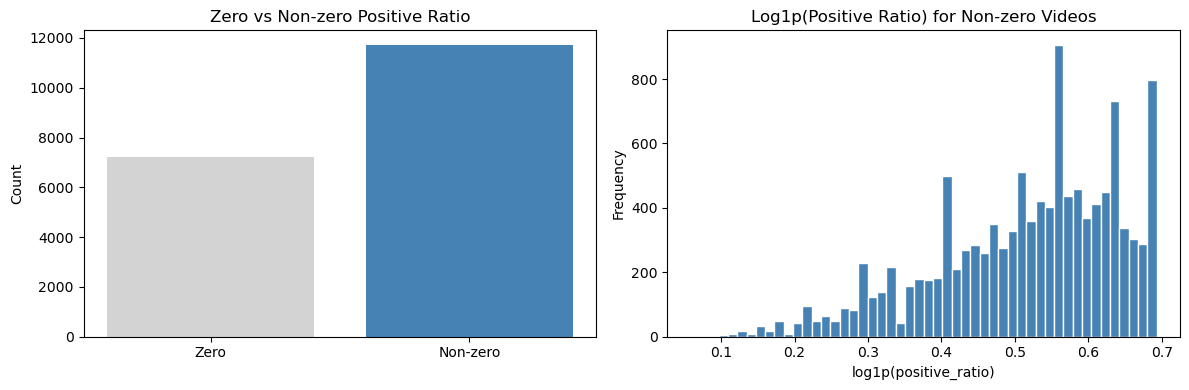

In [316]:
# 1. 計算有多少是 zero vs non-zero
zero_count = (df_all['positive_ratio'] == 0).sum()
nonzero     = df_all.loc[df_all['positive_ratio'] > 0, 'positive_ratio']
nonzero_log = np.log1p(nonzero)  # log1p 轉換

# 2. 畫圖
fig, axes = plt.subplots(1,2, figsize=(12,4))

# 左：bar 顯示 zero vs non-zero 筆數
axes[0].bar(['Zero','Non-zero'], [zero_count, len(nonzero)],
            color=['lightgray','steelblue'])
axes[0].set_title('Zero vs Non-zero Positive Ratio')
axes[0].set_ylabel('Count')

# 右：只看 non-zero 的 log1p 分布
axes[1].hist(nonzero_log, bins=50, color='steelblue', edgecolor='white')
axes[1].set_title('Log1p(Positive Ratio) for Non-zero Videos')
axes[1].set_xlabel('log1p(positive_ratio)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

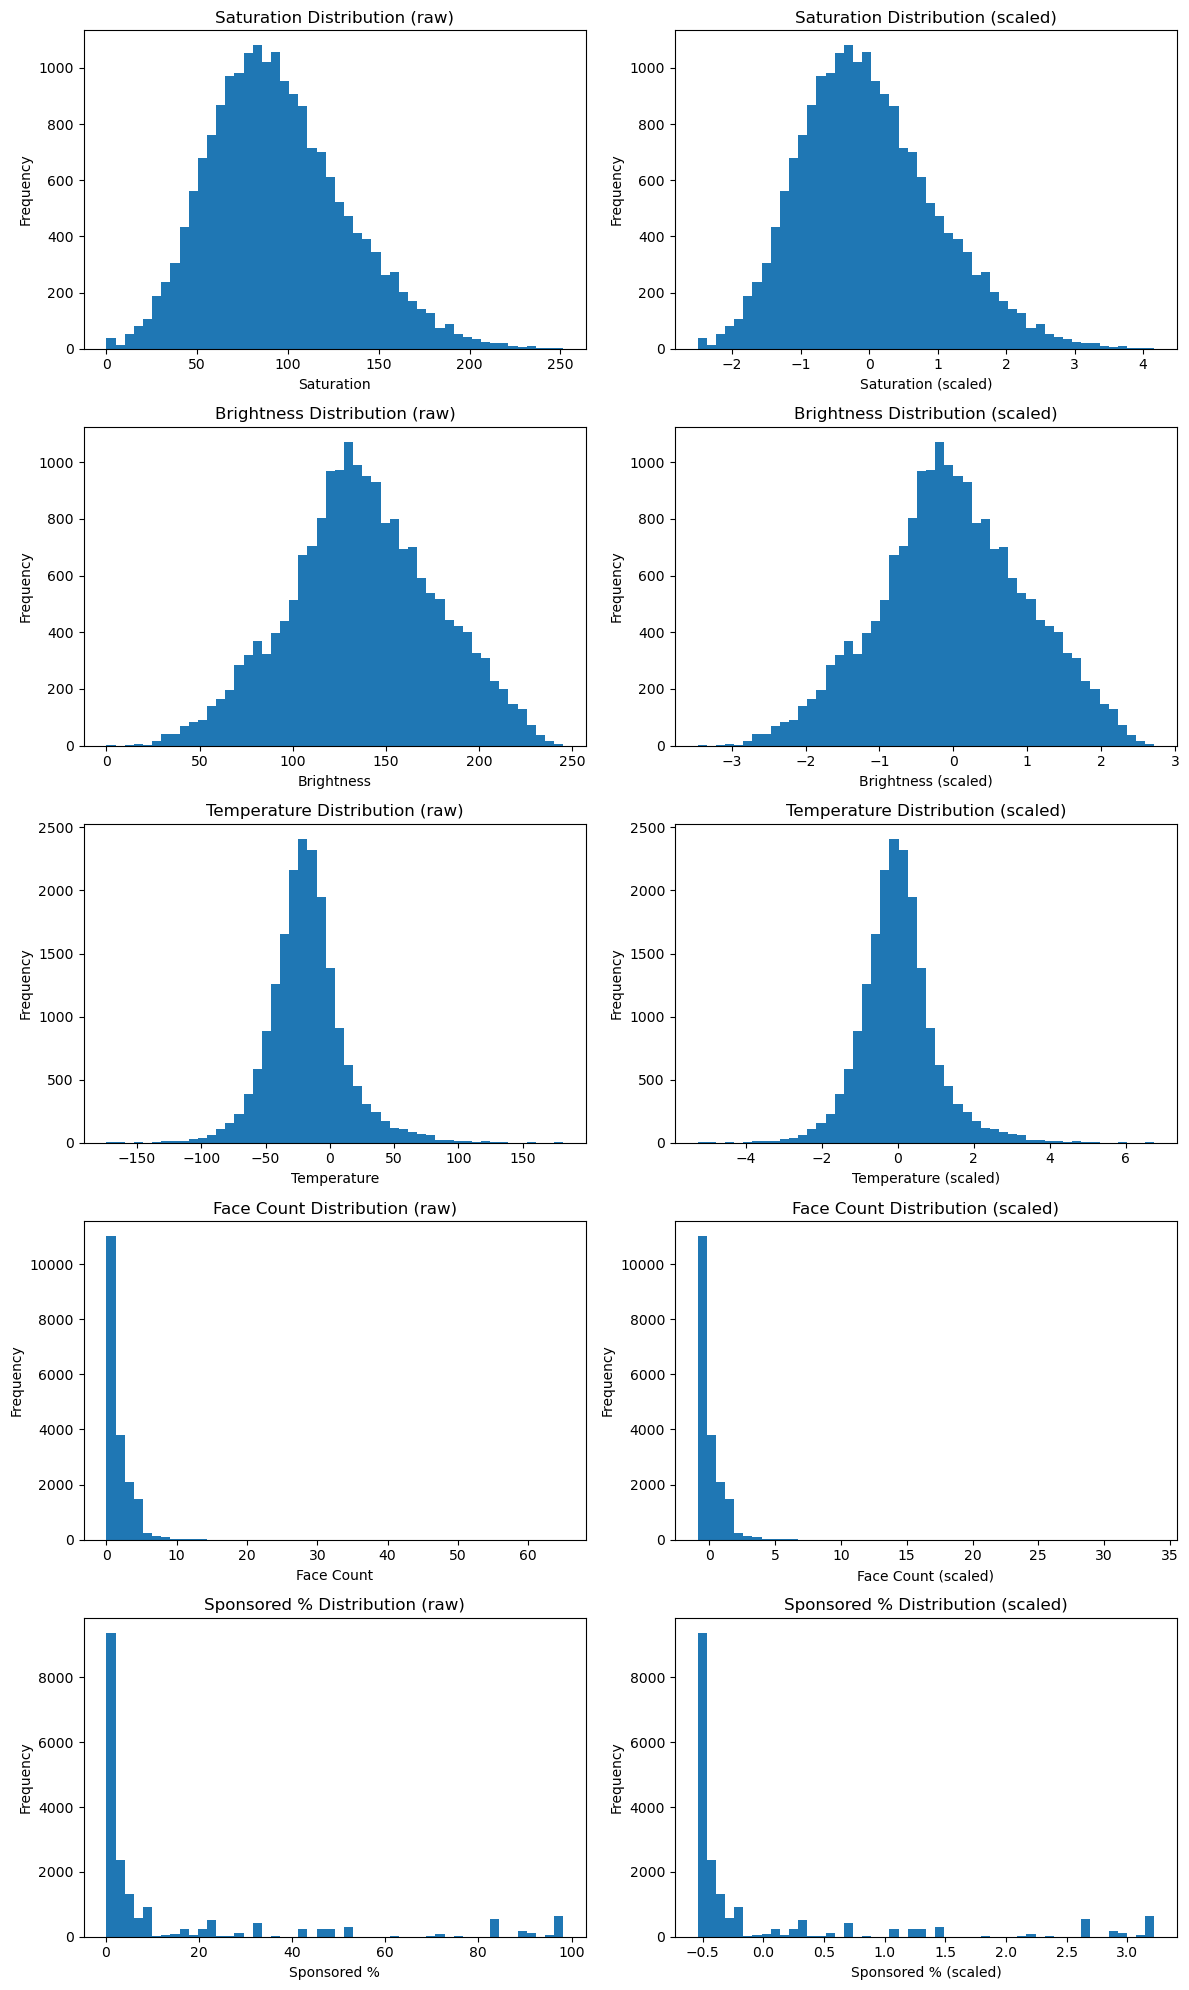

In [325]:
# 要比較的原始指標與對應的 scaled 欄位
metrics        = ['saturation', 'brightness', 'temperature', 'face_count', 'sponsored_content_pct']
scaled_metrics = ['saturation_scaled', 'brightness_scaled', 'temperature_scaled', 'face_count_scaled', 'sponsored_pct_scaled']
titles         = ['Saturation', 'Brightness', 'Temperature', 'Face Count', 'Sponsored %']

# 一共 5 行、2 列：左列原始，右列 scaled
fig, axes = plt.subplots(len(metrics), 2, figsize=(12, 4 * len(metrics)))

for i, title in enumerate(titles):
    raw_col   = metrics[i]
    scaled_col= scaled_metrics[i]

    # 左：原始分布
    ax = axes[i, 0]
    ax.hist(df_all[raw_col], bins=50)
    ax.set_title(f'{title} Distribution (raw)')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')

    # 右：scaled 後的分布
    ax = axes[i, 1]
    ax.hist(df_all[scaled_col], bins=50)
    ax.set_title(f'{title} Distribution (scaled)')
    ax.set_xlabel(f'{title} (scaled)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

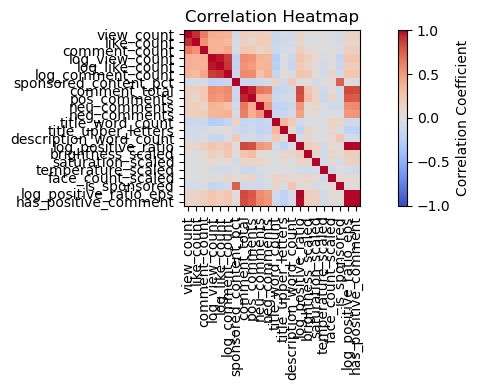

In [327]:
# 選擇數值型欄位
numeric_cols = [
    'view_count', 'like_count', 'comment_count',
    'log_view_count', 'log_like_count', 'log_comment_count',
    'sponsored_content_pct', 'comment_total', 'pos_comments',
    'neu_comments', 'neg_comments',
    'title_word_count', 'title_upper_letters', 'description_word_count',
    'log_positive_ratio', 'brightness_scaled', 'saturation_scaled',
    'temperature_scaled', 'face_count_scaled', 'is_sponsored',
    'log_positive_ratio_eps', 'has_positive_comment'
]

# 計算相關係數矩陣
corr = df_all[numeric_cols].corr()

# 繪製 heatmap
plt.figure(figsize=(8, 4))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Do sponsored videos perform differently from non-sponsored videos within each channel?
### In what ways do sponsorships affect different engagement metrics?

In [334]:
df_all = df_all.copy()
df_all["is_sponsored"] = df_all["sponsorship"].map({"sponsored": 1, "organic": 0})
df_all["channel_id"] = df_all["channel_url"].astype("category").cat.codes  # for regression FE

In [335]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18937 entries, 0 to 18936
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   video_id                                      18937 non-null  object 
 1   title                                         18937 non-null  object 
 2   upload_date                                   18937 non-null  object 
 3   view_count                                    18937 non-null  int64  
 4   like_count                                    18937 non-null  float64
 5   comment_count                                 18937 non-null  float64
 6   description                                   18937 non-null  object 
 7   thumbnail                                     18937 non-null  object 
 8   channel_url                                   18937 non-null  object 
 9   category                                      18937 non-null 

In [336]:
def cohen_d(s, o):
    return (s.mean() - o.mean()) / np.sqrt((s.std() ** 2 + o.std() ** 2) / 2)

def channel_test(group, metric):
    s = group[group["is_sponsored"] == 1][metric]
    o = group[group["is_sponsored"] == 0][metric]
    if len(s) >= 5 and len(o) >= 5:
        t_p = ttest_ind(s, o, equal_var=False).pvalue
        u_p = mannwhitneyu(s, o, alternative="two-sided").pvalue
        effect = cohen_d(s, o)
        return pd.Series({
            "t_pvalue": t_p, "u_pvalue": u_p,
            "sponsored_mean": s.mean(), "organic_mean": o.mean(),
            "sponsored_n": len(s), "organic_n": len(o),
            "cohen_d": effect
        })
    else:
        return pd.Series({
            "t_pvalue": np.nan, "u_pvalue": np.nan,
            "sponsored_mean": np.nan, "organic_mean": np.nan,
            "sponsored_n": len(s), "organic_n": len(o),
            "cohen_d": np.nan
        })

results = []
for metric in ["log_view_count", "log_like_count", "log_comment_count", "log_positive_ratio_eps"]:
    res = df_all.groupby("channel_url").apply(channel_test, metric=metric).reset_index()
    res["metric"] = metric
    results.append(res)

test_results_df = pd.concat(results)

/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/2618742544.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df_all.groupby("channel_url").apply(channel_test, metric=metric).reset_index()
/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/2618742544.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = df_all.groupby("channel_url").apply(channel_test, metric=metr

In [337]:
def run_fe_ols(dep_var):
    formula = f"{dep_var} ~ is_sponsored + C(channel_id)"
    model = smf.ols(formula, data=df_all).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})
    return model

model_view = run_fe_ols("log_view_count")
model_like = run_fe_ols("log_like_count")
model_comment = run_fe_ols("log_comment_count")
model_comment_analysis = run_fe_ols("log_positive_ratio_eps")

In [342]:
def extract_coef(model, label):
    return pd.DataFrame({
        "metric": [label],
        "coef": [model.params.get("is_sponsored", np.nan)],
        "pval": [model.pvalues.get("is_sponsored", np.nan)],
        "r2": [model.rsquared_adj]
    })

summary_df = pd.concat([
    extract_coef(model_view, "views"),
    extract_coef(model_like, "likes"),
    extract_coef(model_comment, "comments"),
    extract_coef(model_comment_analysis, "positive_ratio")
])
summary_df

,metric,coef,pval,r2
0,views,-0.056061,0.695548,0.845092
0,likes,-0.241962,0.143831,0.859495
0,comments,0.187419,0.252845,0.812628
0,positive_ratio,0.076381,0.046825,0.935163


In [350]:
def run_simple_ols(dep_var):
    formula = f"{dep_var} ~ is_sponsored"
    model = smf.ols(formula, data=df_all).fit()
    return model

model_simple_view = run_simple_ols("log_view_count")
model_simple_like = run_simple_ols("log_like_count")
model_simple_comment = run_simple_ols("log_comment_count")
model_simple_sentiment = run_simple_ols("log_positive_ratio")

def extract_coef(model, label):
    return pd.DataFrame({
        "metric": [label],
        "coef": [model.params.get("is_sponsored", np.nan)],
        "pval": [model.pvalues.get("is_sponsored", np.nan)],
        "r2": [model.rsquared_adj]
    })

simple_summary_df = pd.concat([
    extract_coef(model_simple_view, "views"),
    extract_coef(model_simple_like, "likes"),
    extract_coef(model_simple_comment, "comments"),
    extract_coef(model_simple_sentiment, "positive_ratio")
])
simple_summary_df

,metric,coef,pval,r2
0,views,-1.337809,1.895606e-106,0.024993
0,likes,-1.234195,5.766446e-92,0.021560
0,comments,-0.630946,1.011301e-35,0.008134
0,positive_ratio,0.050998,2.313107e-01,0.000023


Models without channel fixed effects show strong and significant coefficients, yet in directions inconsistent with observed audience behavior. The drastic reversal of the sentiment effect from positive (+0.014) to strongly negative (-1.23) illustrates the confounding role of between-channel heterogeneity. Therefore, controlling for within-channel variation is essential for isolating the true sponsorship effect

In [346]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 準備資料
X = df_all[["is_sponsored", "channel_id"]].copy()
y = df_all["has_positive_comment"]

# One-hot encode channel_id（模擬 fixed effects）
encoder = OneHotEncoder(drop='first', sparse_output=False)
channel_dummies = encoder.fit_transform(X[["channel_id"]])
X_encoded = np.hstack([X[["is_sponsored"]].values, channel_dummies])

# 建立模型（加入 ridge regularization）
clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
clf.fit(X_encoded, y)

# 輸出 is_sponsored 係數與 p 值（近似）
is_sponsored_coef = clf.coef_[0][0]
print(f"📌 is_sponsored coef (log-odds): {is_sponsored_coef:.4f}")

📌 is_sponsored coef (log-odds): -0.1098


In [348]:
df_all[df_all["is_sponsored"] == 1]["comment_count"].value_counts(bins=[0, 1, 10, 30, 100, 1000])

(100.0, 1000.0]    1037
(1.0, 10.0]         669
(30.0, 100.0]       147
(10.0, 30.0]         73
(-0.001, 1.0]        57
Name: count, dtype: int64

In [349]:
df_all.groupby("is_sponsored")["comment_count"].describe()

,count,mean,std,min,25%,50%,75%,max
is_sponsored,,,,,,,,
0,16223.0,2984.669235,11441.597581,1.0,52.0,327.0,1900.0,288000.0
1,2714.0,1510.431835,5870.824072,1.0,9.0,324.0,1200.0,136000.0


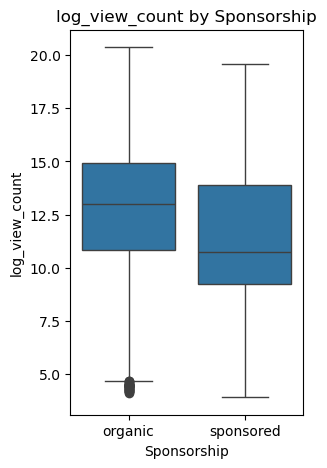

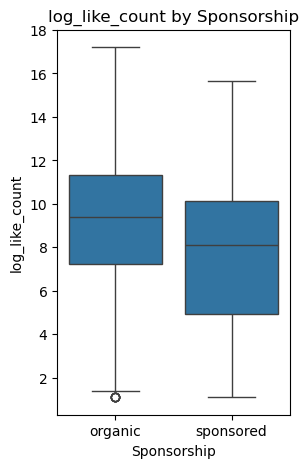

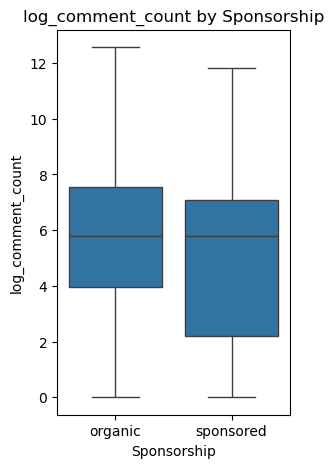

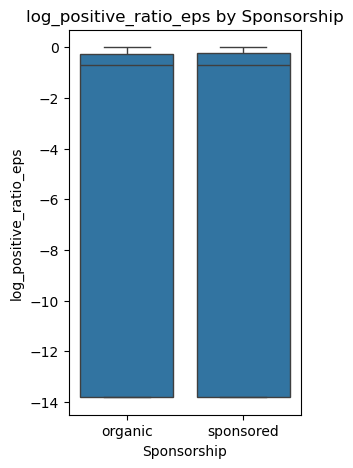

In [351]:
for col in ["log_view_count", "log_like_count", "log_comment_count", "log_positive_ratio_eps"]:
    plt.figure(figsize=(3, 5))
    sns.boxplot(x="sponsorship", y=col, data=df_all)
    plt.title(f"{col} by Sponsorship")
    plt.xlabel("Sponsorship")
    plt.ylabel(col)
    plt.show()

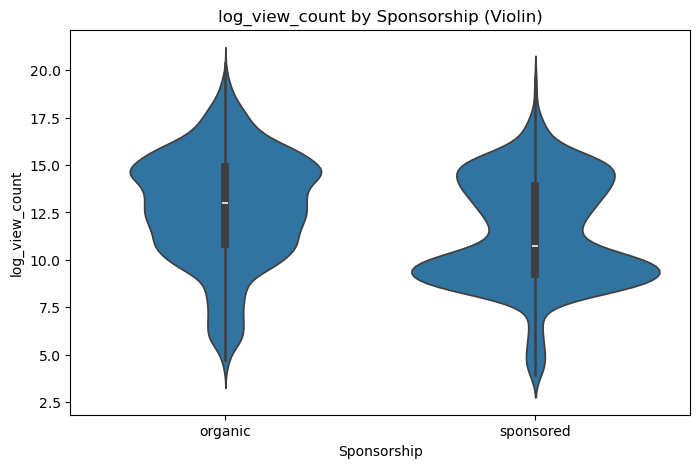

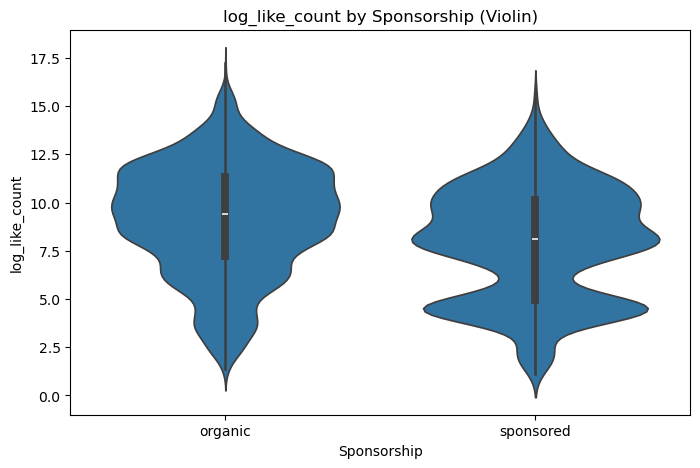

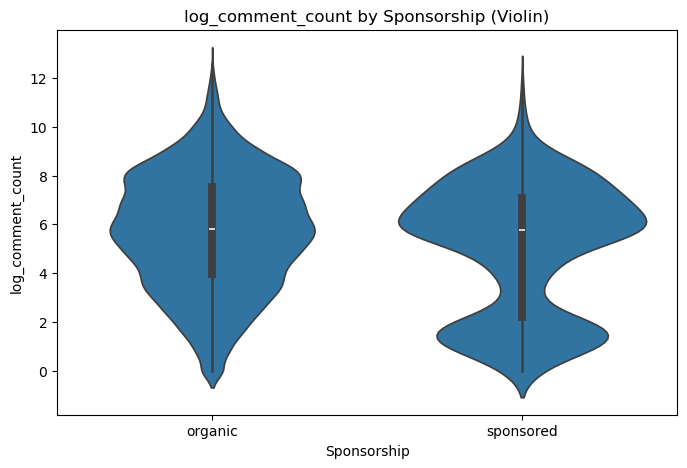

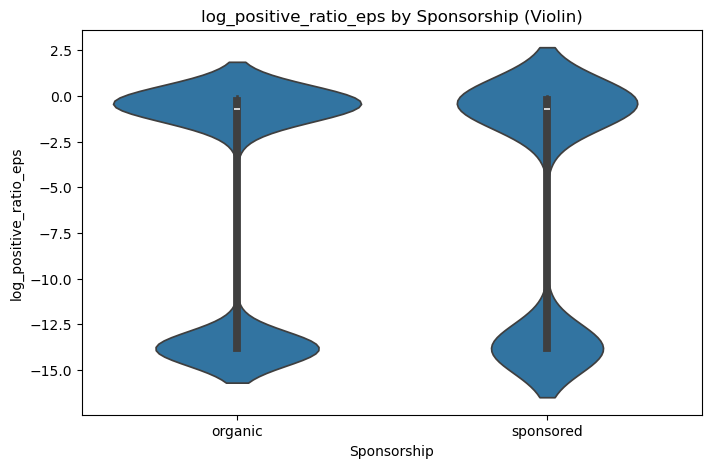

In [341]:
for col in ["log_view_count", "log_like_count", "log_comment_count", "log_positive_ratio_eps"]:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="sponsorship", y=col, data=df_all, inner="box")
    plt.title(f"{col} by Sponsorship (Violin)")
    plt.xlabel("Sponsorship")
    plt.ylabel(col)
    plt.show()

# RQ3

### To what extent do content- and creator-level features moderate sponsorship effects?

In [352]:
def print_key_coefficients(model):
    coef = model.params
    pvals = model.pvalues
    conf_int = model.conf_int()
    
    # 僅保留關鍵變數
    keys = [key for key in coef.index if 'is_sponsored' in key or 'moderator' in key]
    for key in keys:
        print(f"{key}: coef={coef[key]:.4f}, p={pvals[key]:.3f}, 95% CI=({conf_int.loc[key,0]:.4f}, {conf_int.loc[key,1]:.4f})")

## size x sponsored content percentage

In [353]:
model_size_pct = smf.ols(
    "log_view_count ~ is_sponsored * size * sponsored_content_pct + C(channel_id)",
    data=df_all
).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})

print_key_coefficients(model_size_pct)
print(model_size_pct.summary())

is_sponsored: coef=0.0205, p=0.896, 95% CI=(-0.2881, 0.3290)
is_sponsored:size[T.mega]: coef=-0.1974, p=0.467, 95% CI=(-0.7299, 0.3351)
is_sponsored:size[T.micro]: coef=-0.0596, p=0.899, 95% CI=(-0.9829, 0.8637)
is_sponsored:sponsored_content_pct: coef=-0.0025, p=0.351, 95% CI=(-0.0079, 0.0028)
is_sponsored:size[T.mega]:sponsored_content_pct: coef=0.0072, p=0.105, 95% CI=(-0.0015, 0.0160)
is_sponsored:size[T.micro]:sponsored_content_pct: coef=0.0213, p=0.004, 95% CI=(0.0068, 0.0358)
                            OLS Regression Results                            
Dep. Variable:         log_view_count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1327.
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          4.86e-118
Time:                        16:34:09   Log-Likelihood:                -29701.
No. Observations:               18937 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 147, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [360]:
model_size_pct = smf.ols(
    "log_like_count ~ is_sponsored * size * sponsored_content_pct + C(channel_id)",
    data=df_all
).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})

print_key_coefficients(model_size_pct)
print(model_size_pct.summary())

is_sponsored: coef=-0.0262, p=0.867, 95% CI=(-0.3330, 0.2807)
is_sponsored:size[T.mega]: coef=-0.3524, p=0.245, 95% CI=(-0.9470, 0.2423)
is_sponsored:size[T.micro]: coef=-0.9737, p=0.240, 95% CI=(-2.5983, 0.6510)
is_sponsored:sponsored_content_pct: coef=-0.0021, p=0.464, 95% CI=(-0.0076, 0.0035)
is_sponsored:size[T.mega]:sponsored_content_pct: coef=0.0059, p=0.233, 95% CI=(-0.0038, 0.0156)
is_sponsored:size[T.micro]:sponsored_content_pct: coef=0.0259, p=0.059, 95% CI=(-0.0010, 0.0527)
                            OLS Regression Results                            
Dep. Variable:         log_like_count   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     2933.
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          3.45e-141
Time:                        17:24:54   Log-Likelihood:                -28647.
No. Observations:               1893

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 147, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [361]:
model_size_pct = smf.ols(
    "log_comment_count ~ is_sponsored * size * sponsored_content_pct + C(channel_id)",
    data=df_all
).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})

print_key_coefficients(model_size_pct)
print(model_size_pct.summary())

is_sponsored: coef=-0.1357, p=0.415, 95% CI=(-0.4624, 0.1909)
is_sponsored:size[T.mega]: coef=0.2199, p=0.421, 95% CI=(-0.3154, 0.7552)
is_sponsored:size[T.micro]: coef=0.2018, p=0.484, 95% CI=(-0.3639, 0.7675)
is_sponsored:sponsored_content_pct: coef=0.0030, p=0.291, 95% CI=(-0.0025, 0.0085)
is_sponsored:size[T.mega]:sponsored_content_pct: coef=0.0026, p=0.582, 95% CI=(-0.0065, 0.0117)
is_sponsored:size[T.micro]:sponsored_content_pct: coef=0.0148, p=0.002, 95% CI=(0.0054, 0.0242)
                            OLS Regression Results                            
Dep. Variable:      log_comment_count   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     706.4
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          7.15e-100
Time:                        18:25:04   Log-Likelihood:                -27851.
No. Observations:               18937   

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 147, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [362]:
model_size_pct = smf.ols(
    "log_positive_ratio_eps ~ is_sponsored * size * sponsored_content_pct + C(channel_id)",
    data=df_all
).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})

print_key_coefficients(model_size_pct)
print(model_size_pct.summary())

is_sponsored: coef=-0.0023, p=0.991, 95% CI=(-0.4199, 0.4154)
is_sponsored:size[T.mega]: coef=0.1407, p=0.528, 95% CI=(-0.2959, 0.5773)
is_sponsored:size[T.micro]: coef=0.0023, p=0.991, 95% CI=(-0.4154, 0.4199)
is_sponsored:sponsored_content_pct: coef=0.0020, p=0.512, 95% CI=(-0.0040, 0.0080)
is_sponsored:size[T.mega]:sponsored_content_pct: coef=-0.0044, p=0.194, 95% CI=(-0.0111, 0.0023)
is_sponsored:size[T.micro]:sponsored_content_pct: coef=-0.0020, p=0.512, 95% CI=(-0.0080, 0.0040)
                              OLS Regression Results                              
Dep. Variable:     log_positive_ratio_eps   R-squared:                       0.936
Model:                                OLS   Adj. R-squared:                  0.935
Method:                     Least Squares   F-statistic:                     4258.
Date:                    Mon, 07 Jul 2025   Prob (F-statistic):          9.01e-142
Time:                            18:26:34   Log-Likelihood:                -36361.
No. Observati

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 147, but rank is 4
  warnings.warn('covariance of constraints does not have full '


## thumbnail brightness

In [355]:
model_brightness = smf.ols(
    "log_view_count ~ is_sponsored * brightness + C(channel_id)",
    data=df_all
).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})

print_key_coefficients(model_brightness)
print(model_brightness.summary())

is_sponsored: coef=-0.1543, p=0.321, 95% CI=(-0.4592, 0.1506)
is_sponsored:brightness: coef=0.0008, p=0.583, 95% CI=(-0.0020, 0.0035)
                            OLS Regression Results                            
Dep. Variable:         log_view_count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     3933.
Date:                Mon, 07 Jul 2025   Prob (F-statistic):          6.68e-132
Time:                        16:35:12   Log-Likelihood:                -29703.
No. Observations:               18937   AIC:                         5.969e+04
Df Residuals:                   18797   BIC:                         6.079e+04
Df Model:                         139                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 139, but rank is 3
  warnings.warn('covariance of constraints does not have full '


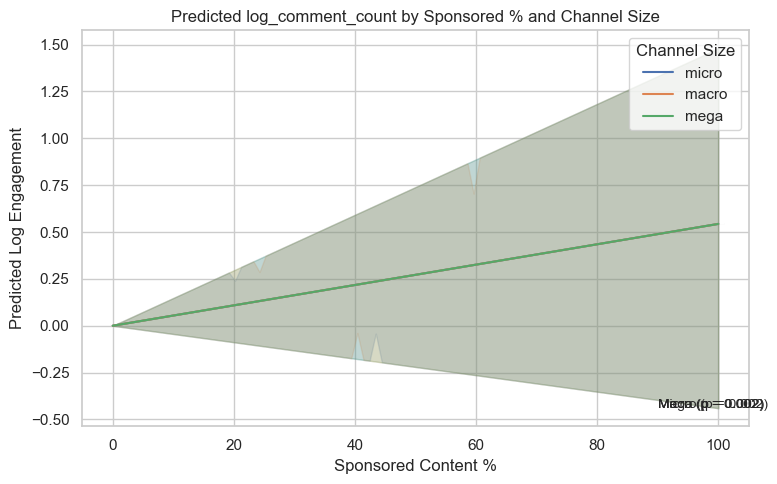

In [373]:
# Step 1: 建立預測資料集
plot_df = pd.DataFrame()
pct_range = np.linspace(0, 100, 100)
for size in ['micro', 'macro', 'mega']:
    for coef, metric, pval in zip([0.0148, 0.0059, -0.0044],  # 改成你實際的coef
                                   ['micro', 'macro', 'mega'],
                                   [0.002, 0.233, 0.194]):     # 寫上 p-value
        temp = pd.DataFrame({
            'Sponsored Content %': pct_range,
            'Predicted Log Engagement': coef * pct_range,
            'Channel Size': size,
            'pval': pval
        })
        plot_df = pd.concat([plot_df, temp])

# Step 2: 繪圖
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=plot_df, x='Sponsored Content %', y='Predicted Log Engagement', hue='Channel Size')

# Step 3: 標註 p 值
for size in ['micro', 'macro', 'mega']:
    sub = plot_df[plot_df['Channel Size'] == size]
    p = sub['pval'].iloc[0]
    x = 90
    y = sub['Predicted Log Engagement'].iloc[-1]
    label = f"{size.capitalize()} (p = {p:.3f})" if p > 0.001 else f"{size.capitalize()} (p < 0.001)"
    ax.text(x, y, label, fontsize=10)

plt.title("Predicted log_comment_count by Sponsored % and Channel Size")
plt.tight_layout()
plt.show()


## All Together

In [363]:
dependent_vars = ["log_view_count", "log_like_count", "log_comment_count", "log_positive_ratio_eps"]
moderators_2way = ["brightness_scaled", "saturation_scaled", "temperature_scaled", "face_count_scaled","title_word_count","title_upper_letters","description_word_count"]
moderator_3way = ("size", "sponsored_content_pct")

# Store regression results
results = []

# Loop over dependent variables and 2-way moderators
for dv in dependent_vars:
    for mod in moderators_2way:
        formula = f"{dv} ~ is_sponsored * {mod} + C(channel_id)"
        model = smf.ols(formula, data=df_all).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})
        for term in model.params.index:
            if "is_sponsored" in term:
                results.append({
                    "metric": dv,
                    "moderator": mod,
                    "term": term,
                    "coef": model.params[term],
                    "pval": model.pvalues[term],
                    "ci_low": model.conf_int().loc[term][0],
                    "ci_high": model.conf_int().loc[term][1]
                })

# Loop over dependent variables for 3-way interaction
size, pct = moderator_3way
for dv in dependent_vars:
    formula = f"{dv} ~ is_sponsored * {size} * {pct} + C(channel_id)"
    model = smf.ols(formula, data=df_all).fit(cov_type="cluster", cov_kwds={"groups": df_all["channel_id"]})
    for term in model.params.index:
        if "is_sponsored" in term:
            results.append({
                "metric": dv,
                "moderator": f"{size} x {pct}",
                "term": term,
                "coef": model.params[term],
                "pval": model.pvalues[term],
                "ci_low": model.conf_int().loc[term][0],
                "ci_high": model.conf_int().loc[term][1]
            })

# Convert to DataFrame for visualisation or export
results_df = pd.DataFrame(results)
results_df.to_csv("Q3final＿final_results_df.csv", index=False)

In [357]:
print(results_df)

                metric                     moderator  \
0       log_view_count             brightness_scaled   
1       log_view_count             brightness_scaled   
2       log_view_count             saturation_scaled   
3       log_view_count             saturation_scaled   
4       log_view_count            temperature_scaled   
..                 ...                           ...   
75  log_positive_ratio  size x sponsored_content_pct   
76  log_positive_ratio  size x sponsored_content_pct   
77  log_positive_ratio  size x sponsored_content_pct   
78  log_positive_ratio  size x sponsored_content_pct   
79  log_positive_ratio  size x sponsored_content_pct   

                                                term      coef      pval  \
0                                       is_sponsored -0.049887  0.702292   
1                     is_sponsored:brightness_scaled  0.030177  0.582716   
2                                       is_sponsored -0.052051  0.717160   
3                     i

# ROBUSTNESS CHECK

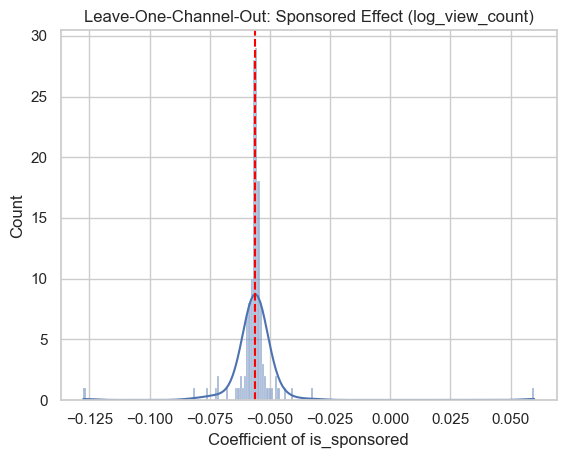

In [374]:
coefs = []
for channel in df_all["channel_id"].unique():
    df_sub = df_all[df_all["channel_id"] != channel]
    model = smf.ols("log_view_count ~ is_sponsored + C(channel_id)", data=df_sub).fit(
        cov_type="cluster", cov_kwds={"groups": df_sub["channel_id"]}
    )
    coefs.append(model.params.get("is_sponsored", np.nan))

sns.histplot(coefs, kde=True)
plt.axvline(np.mean(coefs), color="red", linestyle="--")
plt.title("Leave-One-Channel-Out: Sponsored Effect (log_view_count)")
plt.xlabel("Coefficient of is_sponsored")
plt.show()


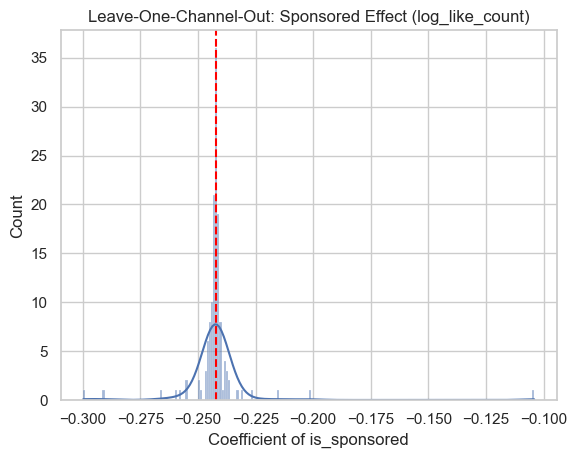

In [378]:
coefs = []
for channel in df_all["channel_id"].unique():
    df_sub = df_all[df_all["channel_id"] != channel]
    model = smf.ols("log_like_count ~ is_sponsored + C(channel_id)", data=df_sub).fit(
        cov_type="cluster", cov_kwds={"groups": df_sub["channel_id"]}
    )
    coefs.append(model.params.get("is_sponsored", np.nan))

sns.histplot(coefs, kde=True)
plt.axvline(np.mean(coefs), color="red", linestyle="--")
plt.title("Leave-One-Channel-Out: Sponsored Effect (log_like_count)")
plt.xlabel("Coefficient of is_sponsored")
plt.show()

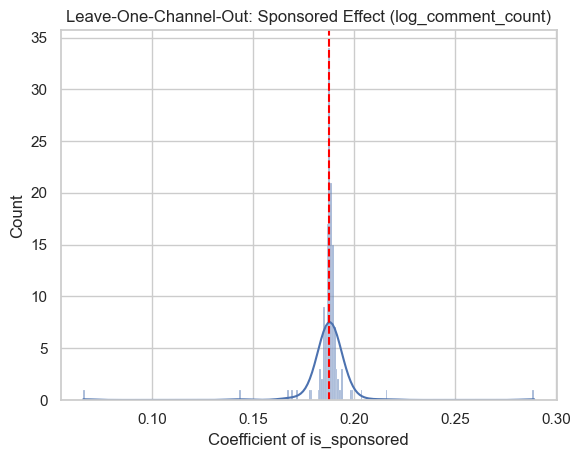

In [379]:
coefs = []
for channel in df_all["channel_id"].unique():
    df_sub = df_all[df_all["channel_id"] != channel]
    model = smf.ols("log_comment_count ~ is_sponsored + C(channel_id)", data=df_sub).fit(
        cov_type="cluster", cov_kwds={"groups": df_sub["channel_id"]}
    )
    coefs.append(model.params.get("is_sponsored", np.nan))

sns.histplot(coefs, kde=True)
plt.axvline(np.mean(coefs), color="red", linestyle="--")
plt.title("Leave-One-Channel-Out: Sponsored Effect (log_comment_count)")
plt.xlabel("Coefficient of is_sponsored")
plt.show()

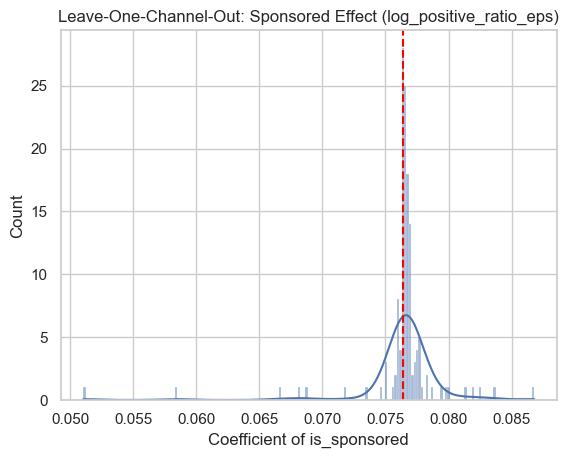

In [380]:
coefs = []
for channel in df_all["channel_id"].unique():
    df_sub = df_all[df_all["channel_id"] != channel]
    model = smf.ols("log_positive_ratio_eps ~ is_sponsored + C(channel_id)", data=df_sub).fit(
        cov_type="cluster", cov_kwds={"groups": df_sub["channel_id"]}
    )
    coefs.append(model.params.get("is_sponsored", np.nan))

sns.histplot(coefs, kde=True)
plt.axvline(np.mean(coefs), color="red", linestyle="--")
plt.title("Leave-One-Channel-Out: Sponsored Effect (log_positive_ratio_eps)")
plt.xlabel("Coefficient of is_sponsored")
plt.show()

To ensure our findings were not driven by a single or small set of highly influential creators, we conducted a leave-one-channel-out (LOCO) robustness check. Each iteration excluded one channel from the sample and re-estimated the sponsorship effect on log view count. The distribution of resulting coefficients remained tightly centered around the full-sample estimate (−0.056), with no extreme shifts. This confirms that the negative sponsorship effect on viewership is robust and not dominated by any particular channel.
We perform a leave-one-channel-out robustness check and find the estimated sponsorship effects on both view count and comment sentiment remain stable across subsets, suggesting the findings are not driven by outlier channels."

/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/3971710987.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_bin')


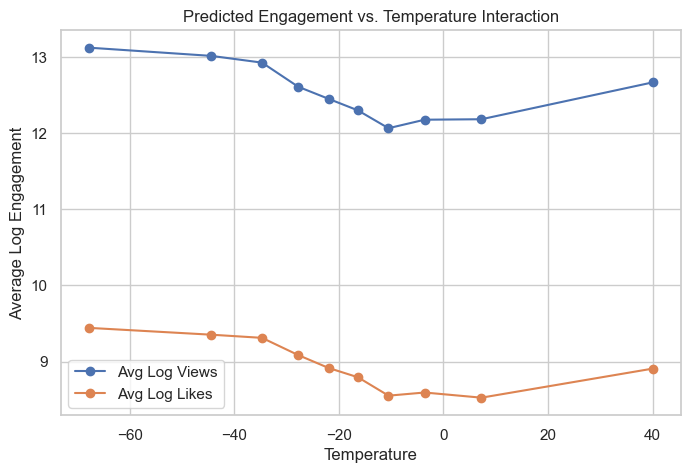

/var/folders/l0/ykw2ykl50r902dn7xl4w6qvw0000gn/T/ipykernel_38254/3971710987.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['bright_bin', 'sponsorship'])


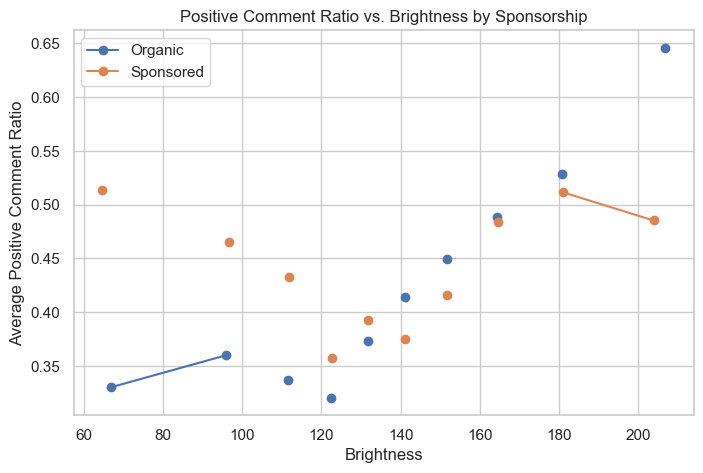

In [381]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Predicted engagement vs. temperature interaction
# ----------------------------------------------------

# Bin temperature into 10 quantiles and compute mean temperature & engagements per bin
df_all['temp_bin'] = pd.qcut(df_all['temperature'], q=10, duplicates='drop')
temp_stats = (
    df_all
    .groupby('temp_bin')
    .agg(
        mean_temp = ('temperature', 'mean'),
        avg_log_views = ('log_view_count', 'mean'),
        avg_log_likes = ('log_like_count', 'mean')
    )
    .reset_index()
)

# Plot interaction: avg_log_views & avg_log_likes over mean_temp
plt.figure(figsize=(8, 5))
plt.plot(temp_stats['mean_temp'], temp_stats['avg_log_views'], marker='o', label='Avg Log Views')
plt.plot(temp_stats['mean_temp'], temp_stats['avg_log_likes'], marker='o', label='Avg Log Likes')
plt.xlabel('Temperature')
plt.ylabel('Average Log Engagement')
plt.title('Predicted Engagement vs. Temperature Interaction')
plt.legend()
plt.grid(True)
plt.show()


# 2. Positive comment ratio vs. brightness (sponsored vs. organic)
# ----------------------------------------------------------------

# Bin brightness into 10 quantiles and compute mean brightness & positive_ratio per sponsorship
df_all['bright_bin'] = pd.qcut(df_all['brightness'], q=10, duplicates='drop')
bright_stats = (
    df_all
    .groupby(['bright_bin', 'sponsorship'])
    .agg(
        mean_brightness = ('brightness', 'mean'),
        avg_pos_ratio = ('positive_ratio', 'mean')
    )
    .reset_index()
)

# Pivot so we have one line per sponsorship
bright_pivot = bright_stats.pivot(
    index='mean_brightness',
    columns='sponsorship',
    values='avg_pos_ratio'
).sort_index()

# Plot two lines: organic vs sponsored
plt.figure(figsize=(8, 5))
for sponsorship_type in bright_pivot.columns:
    plt.plot(
        bright_pivot.index,
        bright_pivot[sponsorship_type],
        marker='o',
        label=sponsorship_type.capitalize()
    )
plt.xlabel('Brightness')
plt.ylabel('Average Positive Comment Ratio')
plt.title('Positive Comment Ratio vs. Brightness by Sponsorship')
plt.legend()
plt.grid(True)
plt.show()
